In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import xarray as xr

from matplotlib.patches import Polygon
from typing import Tuple

sys.executable

'D:\\SynDocs\\Research\\BaPSF\\_repos\\bapsf_motion\\.venvs\\py310_dev\\Scripts\\python.exe'

In [3]:
try:
    from bapsf_motion.motion_builder.exclusions import CircularExclusion, DividerExclusion
except ModuleNotFoundError:
    from pathlib import Path

    HERE = Path().cwd()
    BAPSF_MOTION = (HERE / ".." / ".." / ".." ).resolve()
    sys.path.append(str(BAPSF_MOTION))
    
    from bapsf_motion.motion_builder.exclusions import CircularExclusion, DividerExclusion
    

In [4]:
plt.rcParams.update(
    {
        # "figure.figsize": [12, 0.56 * 12],
        "figure.figsize": [10, 0.8 * 10],
        "font.size": 16,
    }
)

## Prototyping the Shadow

#### Setup

In [5]:
from bapsf_motion.motion_builder.exclusions import LaPDXYExclusion, CircularExclusion

Create a staring blank (all `True`) mask.

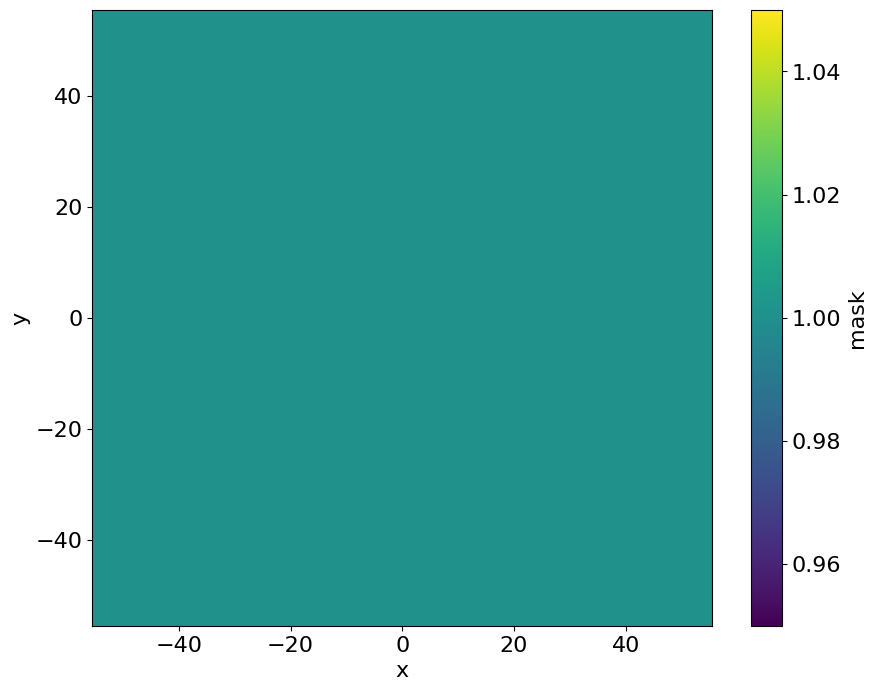

In [439]:
size = 111
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

Populate the mask with a `LaPDXYExclusion` and `CircularExclusion`.  `CircularExclusion` is the element we will want to shadow.

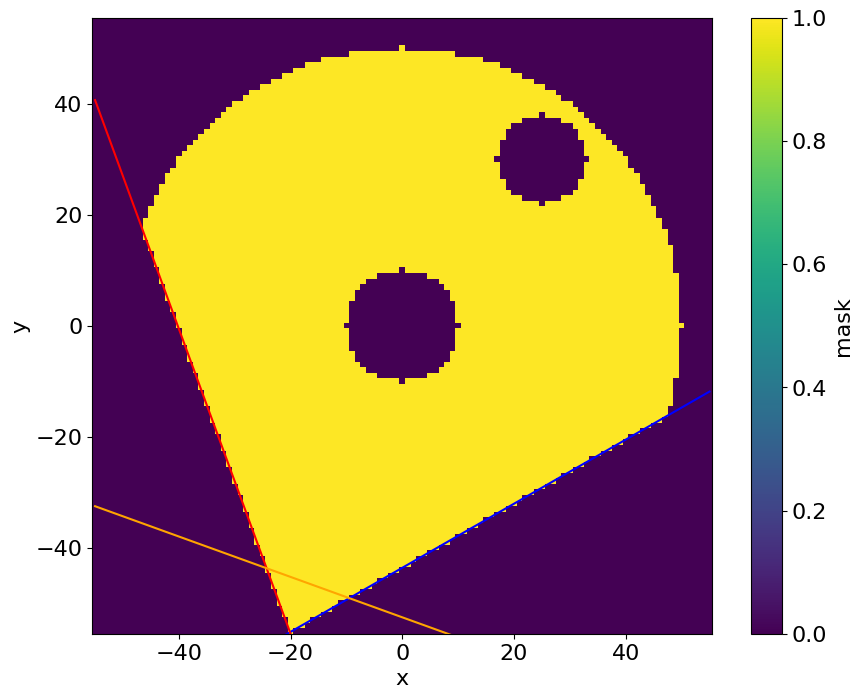

In [440]:
# ex = LaPDXYExclusion(ds, pivot_radius=20)
ex = LaPDXYExclusion(ds, port_location=250)
exC = CircularExclusion(ds, radius=10, center=(0,0), exclude="inside")
exC2 = CircularExclusion(ds, radius=8, center=(25,30), exclude="inside")

ds.mask.plot(x="x", y="y")

colors = ["blue", "red", "orange"]
ii = 0
for subex in ex.composed_exclusions:
    if not isinstance(subex, DividerExclusion):
        continue

    (slope, intercept) = subex.mb
    color = colors[np.mod(ii, len(colors))]
    if np.isinf(slope):
        ylim = plt.gca().get_ylim()
        plt.vlines(intercept, *ylim, color=color)
    else:
        plt.plot(side, slope * side + intercept, color=color)

    ii += 1;

In [441]:
ds

<xarray.Dataset> Size: 51kB
Dimensions:   (x: 111, y: 111)
Coordinates:
  * x         (x) float64 888B -55.0 -54.0 -53.0 -52.0 ... 52.0 53.0 54.0 55.0
  * y         (y) float64 888B -55.0 -54.0 -53.0 -52.0 ... 52.0 53.0 54.0 55.0
Data variables:
    mask      (x, y) bool 12kB False False False False ... False False False
    mask_ex1  (x, y) bool 12kB False False False False ... False False False
    mask_ex2  (x, y) bool 12kB True True True True True ... True True True True
    mask_ex3  (x, y) bool 12kB True True True True True ... True True True True

#### Define functions for building the boundary pool

In [442]:
def _boundary_pool(self):
    res = self.mask_resolution
    dx = 0.5 * res[0]
    dy = 0.5 * res[1]
    pool = None
    x_key, y_key = self.mspace_dims
    x_coord = self.mspace_coords[x_key]
    y_coord = self.mspace_coords[y_key]
    
    _bpool = np.zeros((4, 2, 2))
    _bpool[0,0,:] = [x_coord[0] - dx, y_coord[0] - dy]
    _bpool[0,1,:] = [x_coord[-1] + dx, y_coord[0] - dy]
    _bpool[1,0,:] = [x_coord[-1] + dx, y_coord[0] - dy]
    _bpool[1,1,:] = [x_coord[-1] + dx, y_coord[-1] + dy]
    _bpool[2,0,:] = [x_coord[-1] + dx, y_coord[-1] + dy]
    _bpool[2,1,:] = [x_coord[0] - dx, y_coord[-1] + dy]
    _bpool[3,0,:] = [x_coord[0] - dx, y_coord[-1] + dy]
    _bpool[3,1,:] = [x_coord[0] - dx, y_coord[0] - dy]
    
    return _bpool

boundary_pool = _boundary_pool(ex)
boundary_pool.shape

(4, 2, 2)

In [443]:
def _determine_insertion_edge_indices(self):
    res = self.mask_resolution
    x_key, y_key = self.mspace_dims
    x_coord = self.mspace_coords[x_key]
    y_coord = self.mspace_coords[y_key]
    
    x_range = [x_coord[0] - 0.5 * res[0], x_coord[-1] + 0.5 * res[0]]
    y_range = [y_coord[0] - 0.5 * res[1], y_coord[-1] + 0.5 * res[1]]
    
    if (
        (x_range[0] <= self.insertion_point[0] <= x_range[1])
        and (y_range[0] <= self.insertion_point[1] <= y_range[1])
    ):
        # insertion point is within the motion space
        return None
    
    boundary_pool = _boundary_pool(self)
    insertion_edge_indicies = []

    deltas = boundary_pool[..., 1, :] - boundary_pool[..., 0, :]
    
    # look at horizontal boundaries
    _indices = np.where(np.isclose(deltas[..., 1], 0))[0]
    ii_min, ii_max = (
        _indices 
        if boundary_pool[_indices[0], 0, 1] < boundary_pool[_indices[1], 0, 1]
        else (_indices[1], _indices[0])
    )
    if self.insertion_point[1] > boundary_pool[ii_max, 0, 1]:
        insertion_edge_indicies.append(ii_max)
    elif self.insertion_point[1] < boundary_pool[ii_min, 0, 1]:
        insertion_edge_indicies.append(ii_min)
        
    # look at vertical boundaries
    _indices = np.where(np.isclose(deltas[..., 0], 0))[0]
    ii_min, ii_max = (
        _indices 
        if boundary_pool[_indices[0], 0, 0] < boundary_pool[_indices[1], 0, 0]
        else (_indices[1], _indices[0])
    )
    if self.insertion_point[0] > boundary_pool[ii_max, 0, 0]:
        insertion_edge_indicies.append(ii_max)
    elif self.insertion_point[0] < boundary_pool[ii_min, 0, 0]:
        insertion_edge_indicies.append(ii_min)
    
    return tuple(set(insertion_edge_indicies))


_determine_insertion_edge_indices(ex)    

#### Define functions for building the edge pool

Let's find all the starting and ending point that define a mask edge.  A mask edge is the boundaray where neighboring cells swithc true-ness.

In [444]:
def _add_to_edge_pool(edge, epool=None) -> Tuple[int, np.ndarray]:
    # edge.shape == (2, 2)
    # index_1 -> edge point, 0 = start and 1 = stop
    # index_2 -> edge coordinate (0, 1) = (x, y)
    if epool is None:
        epool = np.array(edge)[np.newaxis, ...]
    else:
        epool = np.concatenate(
            (epool, np.array(edge)[np.newaxis, ...]),
            axis=0,
        )

    return epool.shape[0] - 1, epool

In [445]:
def _build_edge_pool(self, mask: xr.DataArray) -> np.ndarray:
    # Find the (x, y) coordinates for the starting and ending points
    # of an edge in the mask array.  An edge occurs then neighboring
    # cells change values (i.e. switch between True and False)
    res = self.mask_resolution
    pool = None
    x_key, y_key = self.mspace_dims
    x_coord = self.mspace_coords[x_key]
    y_coord = self.mspace_coords[y_key]

    # gather vertical edges
    edge_indices = np.where(np.diff(mask, axis=0))
    ix_array = np.unique(edge_indices[0])

    for ix in ix_array:
        iy_array = edge_indices[1][edge_indices[0] == ix]

        x = x_coord[ix] + 0.5 * res[0]

        if iy_array.size == 1:
            iy = iy_array[0]

            edge = np.array(
                [
                    [x, y_coord[iy] - 0.5 * res[1]],
                    [x, y_coord[iy] + 0.5 * res[1]],
                ]
            )
            eid, pool = self._add_to_edge_pool(edge, pool)
        else:
            jumps = np.where(np.diff(iy_array) != 1)[0]

            starts = np.array([0])
            starts = np.concatenate((starts, jumps + 1))
            starts = iy_array[starts]

            stops = np.concatenate((jumps, [iy_array.size - 1]))
            stops = iy_array[stops]

            for iy_start, iy_stop in zip(starts, stops):
                edge = np.array(
                    [
                        [x, y_coord[iy_start] - 0.5 * res[1]],
                        [x, y_coord[iy_stop] + 0.5 * res[1]],
                    ]
                )
                eid, pool = self._add_to_edge_pool(edge, pool)

    # gather horizontal edges
    edge_indices = np.where(np.diff(mask, axis=1))
    iy_array = np.unique(edge_indices[1])

    for iy in iy_array:
        ix_array = edge_indices[0][edge_indices[1] == iy]

        y = y_coord[iy] + 0.5 * res[1]

        if ix_array.size == 1:
            ix = ix_array[0]

            edge = np.array(
                [
                    [x_coord[ix] - 0.5 * res[0], y],
                    [x_coord[ix] + 0.5 * res[0], y],
                ]
            )
            eid, pool = self._add_to_edge_pool(edge, pool)
        else:
            jumps = np.where(np.diff(ix_array) != 1)[0]

            starts = np.array([0])
            starts = np.concatenate((starts, jumps + 1))
            starts = ix_array[starts]

            stops = np.concatenate((jumps, [ix_array.size - 1]))
            stops = ix_array[stops]

            for ix_start, ix_stop in zip(starts, stops):
                edge = np.array(
                    [
                        [x_coord[ix_start] - 0.5 * res[0], y],
                        [x_coord[ix_stop] + 0.5 * res[0], y],
                    ]
                )
                eid, pool = self._add_to_edge_pool(edge, pool)

    # TODO: add perimeter edges
    # - I [Erik] do not think this is needed since it is logical to
    #   assume the true-ness value stays constant across the
    #   boundary
    
    boundary_pool = _boundary_pool(self)
    _insertion_sides = _determine_insertion_edge_indices(self)
    if _insertion_sides is None: _insertion_sides = ()
    for ii in range(4):
        edge = boundary_pool[ii, ...]
        delta = edge[1,:] - edge[0,:]
        edge_type = "horizontal" if np.isclose(delta[1], 0) else "vertical"

        if edge_type == "horizontal":
            edge_vals = mask.sel(**{y_key: edge[0, 1], "method": "nearest"})
        else:
            edge_vals = mask.sel(**{x_key: edge[0, 0], "method": "nearest"})

        compare_val = True if ii in _insertion_sides else False
        _condition = edge_vals == compare_val
        if np.all(_condition):
            # not an edge
            pass
        elif np.all(np.logical_not(_condition)):
            # whole side is an edge
            eid, pool = self._add_to_edge_pool(edge, pool)
#             pass
        else:
            # array contain edges and non-edges
            # False entries are edges
            boundary_edge_indices = np.where(np.diff(_condition))[0] + 1
            if _condition[0] == False:
                boundary_edge_indices = np.insert(boundary_edge_indices, 0, 0)
            if _condition[-1] == False:
                boundary_edge_indices = np.append(boundary_edge_indices, _condition.size-1)

            for ii in range(0, boundary_edge_indices.size, 2):
                istart = boundary_edge_indices[ii]
                istop = boundary_edge_indices[ii+1] - 1

                if edge_type == "horizontal":
                    new_edge = np.array(
                        [
                            [x_coord[istart] - 0.5 * res[0], edge[0, 1]],
                            [x_coord[istop] + 0.5 * res[0], edge[0, 1]],
                        ],
                    )
                else:
                    new_edge = np.array(
                        [
                            [edge[0, 0], y_coord[istart] - 0.5 * res[1]],
                            [edge[0, 0], y_coord[istop] + 0.5 * res[1]],
                        ],
                    )

                eid, pool = self._add_to_edge_pool(new_edge, pool)

    return pool

#### Calculatdata_vars& Plot Edge Pool

In [446]:
mask = np.logical_and(ds[exC.name], ds[exC2.name])
edge_pool = _build_edge_pool(ex, mask)
edge_pool.shape

(100, 2, 2)

In [447]:
edge_pool[-4::,...]

array([[[-55.5, -55.5],
        [ 55.5, -55.5]],

       [[ 55.5, -55.5],
        [ 55.5,  55.5]],

       [[ 55.5,  55.5],
        [-55.5,  55.5]],

       [[-55.5,  55.5],
        [-55.5, -55.5]]])

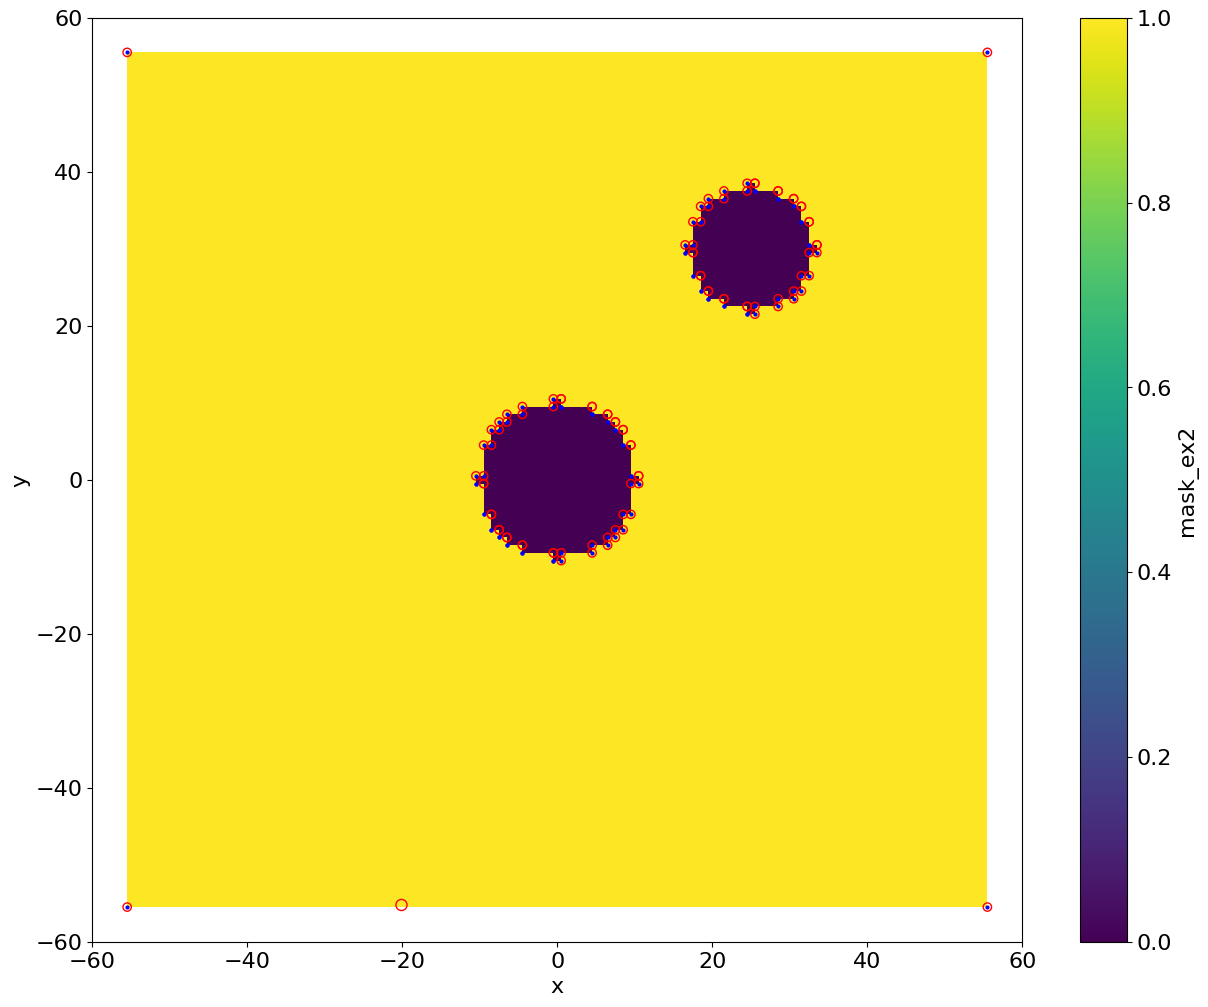

In [448]:
# ds.mask.plot(x="x", y="y", aspect=1.25, size=12)
mask.plot(x="x", y="y", aspect=1.25, size=12)
# ds[exC2.name].plot()

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(edge_pool[..., 0, 0], edge_pool[..., 0, 1], color="blue", s=2**2)
plt.scatter(edge_pool[..., 1, 0], edge_pool[..., 1, 1], facecolors="none", edgecolors="red", s=6**2)
# plt.scatter(boundary_pool[..., 0, 0], boundary_pool[..., 0, 1], color="deeppink", s=4**2)
plt.scatter(ex.insertion_point[0], ex.insertion_point[1], facecolors="none", edgecolors="red", s=8**2)

#### Calcualte & Plot Unique Corner Rays

In [449]:
def _build_corner_rays(self, edge_pool):
    # collect unique edge points (i.e. unique (x,y) coords of edge
    # segment start and stop locations)
    edge_points = edge_pool.reshape(-1, 2)
    edge_points = np.unique(edge_points, axis=0)

    corner_rays = edge_points - self.insertion_point

    # sort corner_rays and edge_points corresponding to the ray angle
    delta = edge_points - self.insertion_point[np.newaxis, :]
    perp_indices = np.where(delta[..., 0] == 0)[0]
    if perp_indices.size > 0:
        delta[perp_indices, 0] = 1  # dx
        delta[perp_indices, 1] = np.inf * (
                delta[perp_indices, 1] / np.abs(delta[perp_indices, 1])
        )  # dy
    ray_angles = np.arctan(delta[..., 1] / delta[..., 0])
    sort_i = np.argsort(ray_angles)
    corner_rays = corner_rays[sort_i]
    edge_points = edge_points[sort_i]

    return corner_rays

In [450]:
def _build_corner_ray_mask(self, corner_rays, edge_pool):
    edge_vectors = edge_pool[..., 1, :] - edge_pool[..., 0, :]

    # determine if a corner_ray intersects an edge that is closer
    # to the insertion point
    # - solving the eqn:
    #
    #   insertion_point + mu * corner_ray = edge_pool[..., 0, :] + nu * edge_vector
    #
    #   * mu and nu are scalars
    #   * if 0 < mu < 1 and 0 < nu < 1, then the corner_ray passes through a
    #     closer edge to the insertion point
    #
    mu_array = (
            np.cross(edge_pool[..., 0, :] - self.insertion_point, edge_vectors)
            / np.cross(corner_rays, edge_vectors[:, np.newaxis, ...]).swapaxes(0, 1)
    )
    nu_array = (
            np.cross(
                (self.insertion_point - edge_pool[..., 0, :])[:, np.newaxis, ...],
                corner_rays
            ).swapaxes(0, 1)
            / np.cross(edge_vectors[:, np.newaxis, ...], corner_rays).swapaxes(0, 1)
    )
    mu_condition = np.logical_and(mu_array >= 0, mu_array < 1)
    nu_condition = np.logical_and(nu_array >= 0, nu_array <= 1)
    _condition = np.logical_and(mu_condition, nu_condition)
    _count = np.count_nonzero(_condition, axis=1)

    return _count == 0

In [451]:
corner_rays = _build_corner_rays(ex, edge_pool)
ray_mask = _build_corner_ray_mask(ex, corner_rays, edge_pool)
corner_rays = corner_rays[ray_mask]
(corner_rays.shape, ray_mask.shape)

((27, 2), (100,))

In [452]:
end_points = corner_rays + ex.insertion_point[np.newaxis, :]
end_points.shape

(27, 2)

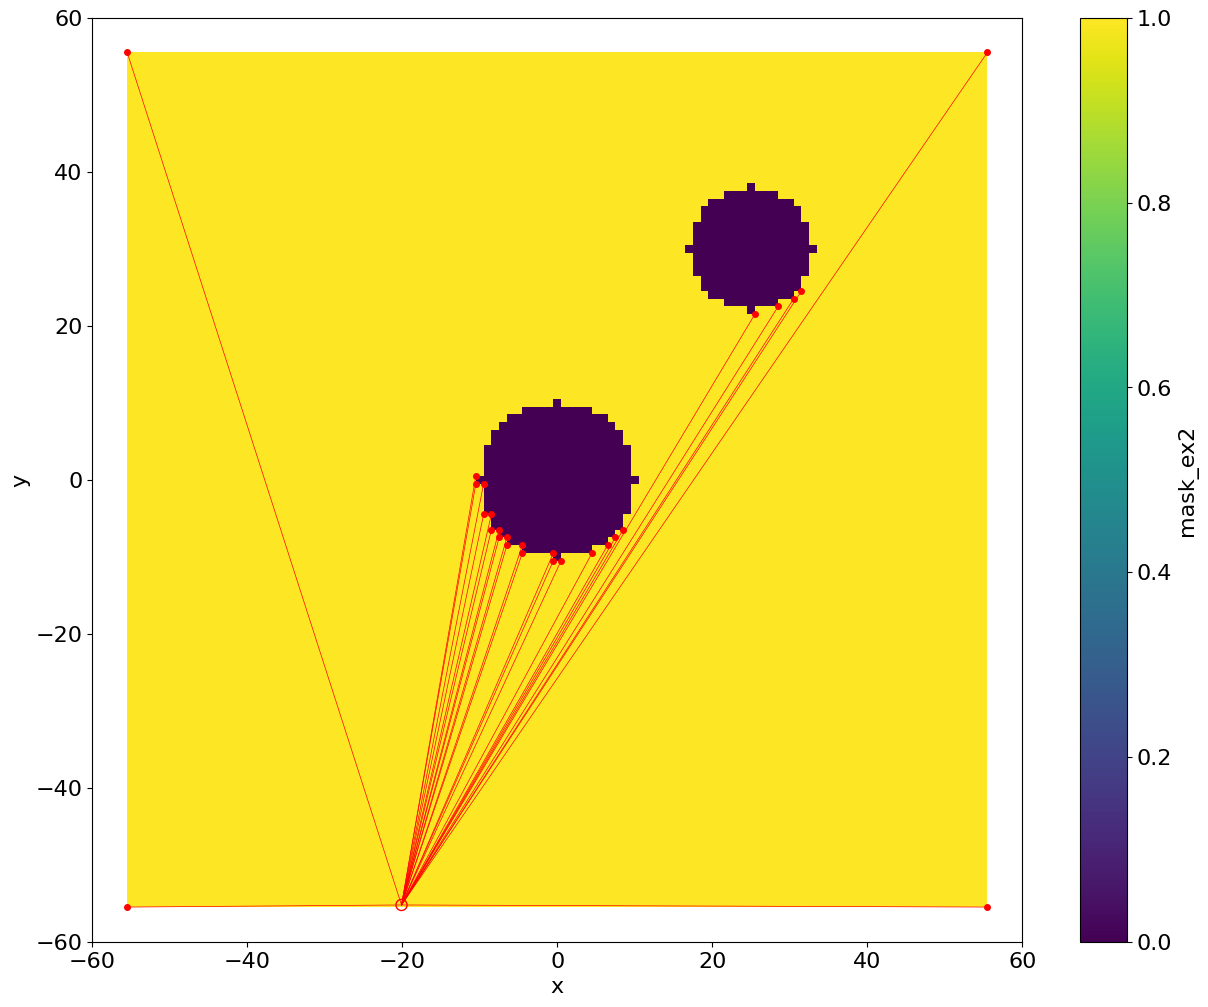

In [453]:
# ds.mask.plot(x="x", y="y", aspect=1.25, size=12)
mask.plot(x="x", y="y", aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(end_points[..., 0], end_points[..., 1], color="red", s=4**2)
plt.scatter(ex.insertion_point[0], ex.insertion_point[1], facecolors="none", edgecolors="red", s=8**2)

for ii in range(end_points.shape[0]):
    plt.plot(
        [ex.insertion_point[0], end_points[ii, 0]],
        [ex.insertion_point[1], end_points[ii, 1]],
        color="red",
        linewidth=0.5,
    )

#### Generate Fanned Rays

In [454]:
def _build_fan_rays(self, corner_rays, edge_pool):
    dx, dy = self.mask_resolution
    
    # calculate angles of corner_rays
    angles = np.arcsin(corner_rays[..., 1] / np.linalg.norm(corner_rays, axis=1))
    corner_ray_angles = np.where(corner_rays[..., 0] >=0, angles, np.pi - angles)
    
#     delta_angle = 0.02 * np.sqrt(dx**2 + dy**2) / np.linalg.norm(corner_rays, axis=1)
    delta_angle = 0.02 * np.min(self.mask_resolution) / np.linalg.norm(corner_rays, axis=1)
    
    # generate fanned rays
    fan_plus = np.linalg.norm(corner_rays, axis=1) * [
        np.cos(corner_ray_angles + delta_angle),
        np.sin(corner_ray_angles + delta_angle),
    ]
    fan_plus = fan_plus.swapaxes(0,1)

    fan_minus = np.linalg.norm(corner_rays, axis=1) * [
        np.cos(corner_ray_angles - delta_angle),
        np.sin(corner_ray_angles - delta_angle),
    ]
    fan_minus = fan_minus.swapaxes(0,1)

    fan_rays = np.concatenate(
        (fan_plus, fan_minus),
        axis=0,
    )
    
    # sort fan rays
    ray_angles = np.arcsin(fan_rays[..., 1] / np.linalg.norm(fan_rays, axis=1))
    ray_angles = np.where(fan_rays[..., 0] >=0, ray_angles, np.pi - ray_angles)
    sort_i = np.argsort(ray_angles)
    fan_rays = fan_rays[sort_i]
    
    # project fan rays to the nearest edge
    edge_vectors = edge_pool[..., 1, :] - edge_pool[..., 0, :]
    
    mu_array = (
        np.cross(edge_pool[..., 0, :] - self.insertion_point, edge_vectors) 
        / np.cross(fan_rays, edge_vectors[:, np.newaxis, ...]).swapaxes(0, 1)
    )
    
    nu_array = (
        np.cross((self.insertion_point - edge_pool[..., 0, :])[:, np.newaxis, ...], fan_rays).swapaxes(0, 1)
        / np.cross(edge_vectors[:, np.newaxis, ...], fan_rays).swapaxes(0, 1)
    )
    
    mu_condition = mu_array > 0
    nu_condition = np.logical_and(nu_array >= 0, nu_array <= 1)
    mask = np.logical_and(mu_condition, nu_condition)
    
    mu_array[np.logical_not(mask)] = np.inf
    adjusted_mu_array = np.nanmin(mu_array, axis=1)
    
    # filter rays that go to infinity (these rays never enter the motion space)
#     finite_mask = np.isfinite(adjusted_mu_array)
    
#     fan_rays = adjusted_mu_array[finite_mask, None] * fan_rays[finite_mask, :]
    fan_rays = adjusted_mu_array[..., None] * fan_rays
    
    return fan_rays
    

In [455]:
fan_rays = _build_fan_rays(ex, corner_rays, edge_pool)
(
    corner_rays.shape,
    fan_rays.shape,
)

((27, 2), (54, 2))

In [456]:
dx, dy = ex.mask_resolution
(
    np.isclose(fan_rays[1::2, 0], corner_rays[..., 0], atol=.95 * dx),
    np.isclose(fan_rays[1::2, 1], corner_rays[..., 1], atol=.95 * dy),
)

(array([False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]))

In [457]:
def _merge_corner_and_fan_rays(self, corner_rays, fan_rays):
    # filter close points before merging
    dx, dy = ex.mask_resolution
    mask1 = np.logical_and(
        np.isclose(fan_rays[0::2, 0], corner_rays[..., 0], atol=.5 * dx),
        np.isclose(fan_rays[0::2, 1], corner_rays[..., 1], atol=.5 * dy),
    )
    mask2 = np.logical_and(
        np.isclose(fan_rays[1::2, 0], corner_rays[..., 0], atol=.5 * dx),
        np.isclose(fan_rays[1::2, 1], corner_rays[..., 1], atol=.5 * dy),
    )
    mask = np.ones((fan_rays.shape[0],), dtype="bool")
    mask[0::2] = np.logical_not(mask1)
    mask[1::2] = np.logical_not(mask2)
    _fan_rays = fan_rays[mask]
    finite_mask = np.all(np.isfinite(_fan_rays), axis=1)
    _fan_rays = _fan_rays[finite_mask]
    
    # merge rays
    _rays = np.concatenate((corner_rays, _fan_rays), axis=0)
    
    # sort rays by angle
    angles = np.arcsin(_rays[..., 1] / np.linalg.norm(_rays, axis=1))
    angles = np.where(_rays[..., 0] >=0, angles, np.pi - angles)
    sort_i = np.argsort(angles)
    _rays = _rays[sort_i]
    
    return _rays

In [458]:
rays = _merge_corner_and_fan_rays(ex, corner_rays, fan_rays)
rays.shape

(81, 2)

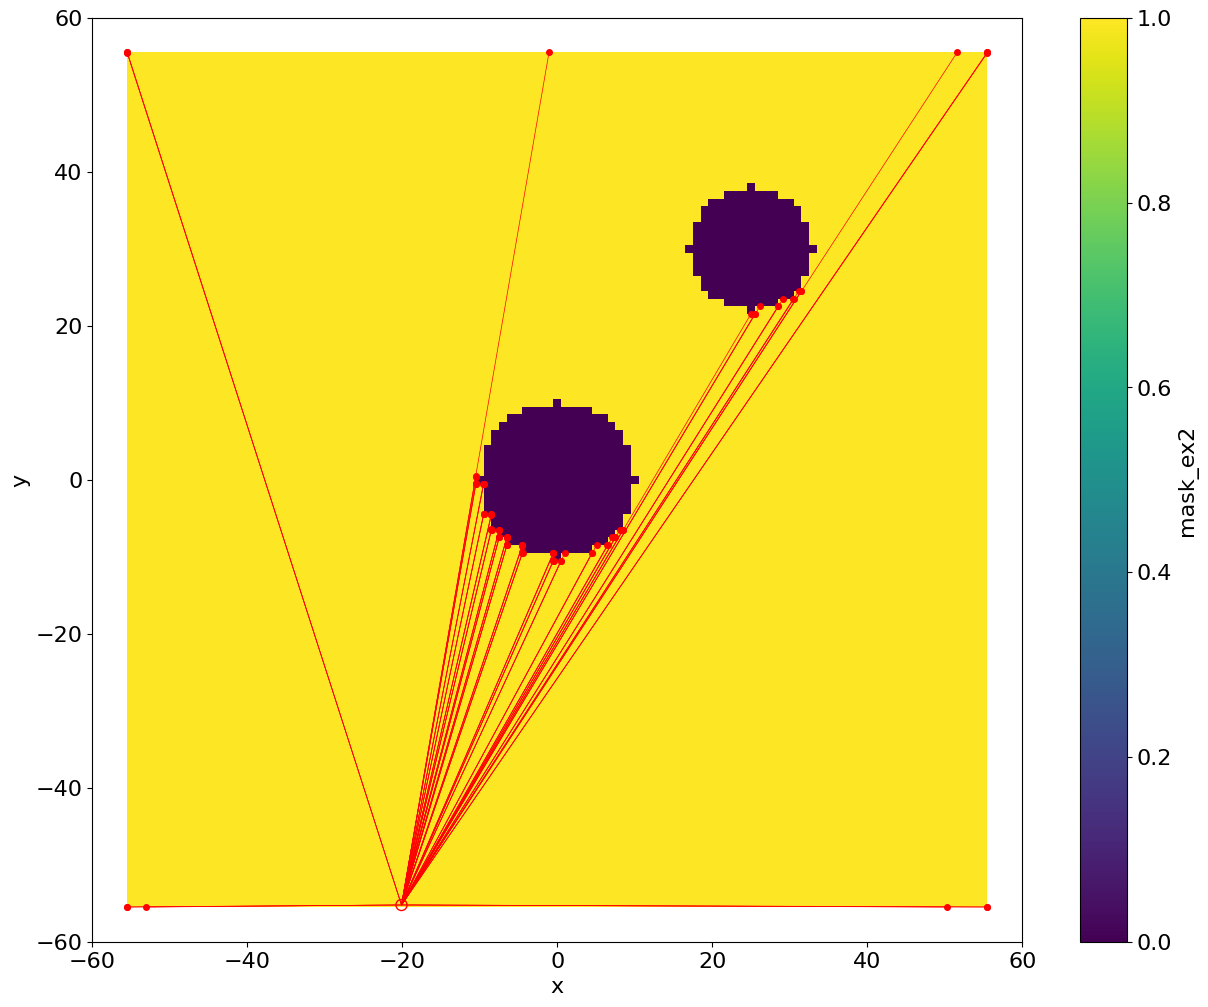

In [459]:
end_points = rays + ex.insertion_point[np.newaxis, :]
end_points.shape

# ds.mask.plot(x="x", y="y", aspect=1.25, size=12)
mask.plot(x="x", y="y", aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(end_points[..., 0], end_points[..., 1], color="red", s=4**2)
plt.scatter(ex.insertion_point[0], ex.insertion_point[1], facecolors="none", edgecolors="red", s=8**2)

for ii in range(end_points.shape[0]):
    plt.plot(
        [ex.insertion_point[0], end_points[ii, 0]],
        [ex.insertion_point[1], end_points[ii, 1]],
        color="red",
        linewidth=0.5,
    )

# plt.scatter(fan_ray_endpoints[..., 0], fan_ray_endpoints[..., 1], color="blue", s=4**2)

#### Paint Mask

In [460]:
def _paint_mask(self, rays: np.ndarray):
    
    x_key, y_key = self.mspace_dims
    x_coord = self.mspace_coords[x_key]
    y_coord = self.mspace_coords[y_key]
    
    rays = np.append(rays, rays[0,...][None, ...], axis=0)
    endpoints = rays + self.insertion_point[None, :]
    
    triangles = np.zeros((rays.shape[0] - 1, 3, 2))
    triangles[..., 0, :] = self.insertion_point
    triangles[..., 1, :] = endpoints[:-1, :]
    triangles[..., 2, :] = endpoints[1:, :]
    
    grid_points = np.zeros((x_coord.size, y_coord.size, 2))
    grid_points[..., 0] = np.repeat(x_coord.values[..., np.newaxis], y_coord.size, axis=1)
    grid_points[..., 1] = np.repeat(y_coord.values[np.newaxis, ...], x_coord.size, axis=0)
    
    # This processes used Barycentric coordinates to determin if a grid point is within
    # the triangle.
    #
    # https://en.wikipedia.org/wiki/Barycentric_coordinate_system
    #
    # lambda shape is (x_size, y_size, N_rays)
    num = np.cross(
        grid_points[:, :, None, :] - triangles[None, None, :, 0, :],
        (triangles[:, 1, :] - triangles[:, 0, :])[None, None, :, :],
    )
    denom = np.cross(
        triangles[:, 2, :] - triangles[:, 0, :],
        triangles[:, 1, :] - triangles[:, 0, :]
    )
    lambda_3 = num / denom[None, None, ...]
    
    num  = np.cross(
        grid_points[:, :, None, :] - triangles[None, None, :, 0, :],
        (triangles[:, 2, :] - triangles[:, 0, :])[None, None, :, :],
    )
#     denom = np.cross(
#         triangles[:, 1, :] - triangles[:, 0, :],
#         triangles[:, 2, :] - triangles[:, 0, :]
#     )
    denom = -denom

    lambda_2 = num / denom[None, None, ...]
    
    lambda_1 = 1 - lambda_2 - lambda_3
    
    lambda_1_condition = np.logical_and(lambda_1 >= 0, lambda_1 <= 1)
    lambda_2_condition = np.logical_and(lambda_2 >= 0, lambda_2 <= 1)
    lambda_3_condition = np.logical_and(lambda_3 >= 0, lambda_3 <= 1)
    
    _condition = np.logical_and(
        np.logical_and(lambda_1_condition, lambda_2_condition),
        lambda_3_condition,
    )
    
    return np.any(_condition, axis=2)

In [461]:
shadow_mask = _paint_mask(ex, rays)

In [462]:
x_key, y_key = ex.mspace_dims
x_coord = ex.mspace_coords[x_key]
y_coord = ex.mspace_coords[y_key]
ds["shadow"] = xr.DataArray(
    data=shadow_mask,
    coords={x_key: x_coord, y_key: y_coord},
)

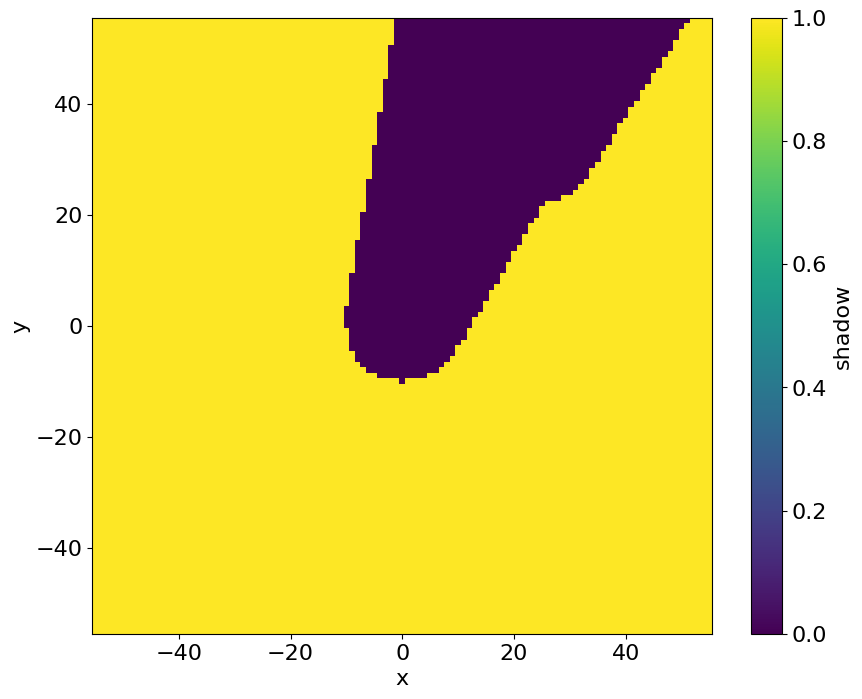

In [463]:
ds.shadow.plot(x="x", y="y")

## Create LaPD XY exclusion mask using elementry exclusions

Create the seeding boolean mask.  In the boolean mask a `True` value indicates a point allowed for a motion list and a `False` value indicaes an exclusion zone.

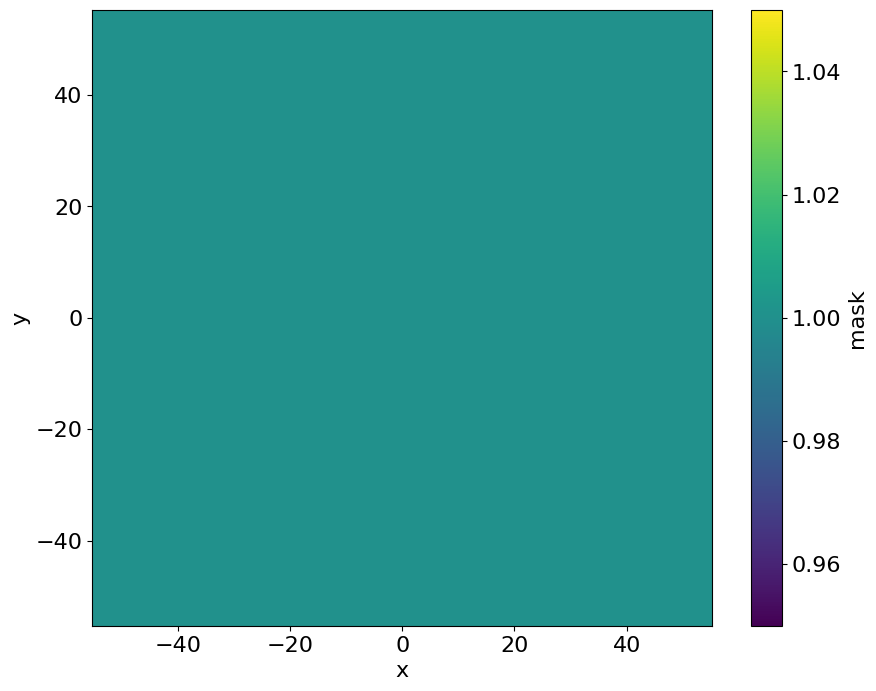

In [141]:
size = 221
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

Add a circular XY exclusion that simulates the LaPD inner diameter

In [ ]:
ex1 = CircularExclusion(ds, radius=50)
ds["mask"].plot(x="x", y="y");

Let's add boundaries representing the exclusion cone from the East port.

In [ ]:
x_pivot = 58.771
cone_half_angle = 40  # degrees

intercept = np.abs(x_pivot) * np.tan(np.radians(cone_half_angle))
slope = intercept / np.abs(x_pivot)

print(isinstance(intercept, float))

ex2 = DividerExclusion(
    ds,
    mb=(-slope, intercept),
    exclude="+e1",
)
ex3 = DividerExclusion(
    ds,
    mb=(slope, -intercept),
    exclude="-e1",
)
ds["mask"].plot(x="x", y="y");

In [ ]:
ds

## Generate a LaPD mask using `LaPDXYExclusion`

In [ ]:
from bapsf_motion.motion_builder.exclusions import LaPDXYExclusion

In [ ]:
size = 100
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

The default settings for the for `LaPDXYExclusion` are the same as the manually constructed exclusion mask above.

In [ ]:
ex = LaPDXYExclusion(ds, cone_full_angle=50, pivot_radius=90)

ds.mask.plot(x="x", y="y")

colors = ["blue", "red", "orange"]
ii = 0
for subex in ex.composed_exclusions:
    if not isinstance(subex, DividerExclusion):
        continue

    (slope, intercept) = subex.mb
    color = colors[np.mod(ii, len(colors))]
    if np.isinf(slope):
        ylim = plt.gca().get_ylim()
        plt.vlines(intercept, *ylim, color=color)
    else:
        plt.plot(side, slope * side + intercept, color=color)

    ii += 1
# mb = ex.composed_exclusions[1].mb
# plt.plot(side, mb[0] * side + mb[1], color="blue")

# mb = ex.composed_exclusions[2].mb
# plt.plot(side, mb[0] * side + mb[1], color="red");

In [ ]:
ex._ds

In [ ]:
ex.mask_resolution

In [ ]:
ex.composed_exclusions
for subex in ex.composed_exclusions:
    print(subex.name)

Additionally, port locations can be specified using values of `E`, `East`, `W`, `West`, `T`, `Top`, `B`, and `Bottom` (all are case insensitive).

In [ ]:
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ex = LaPDXYExclusion(ds, port_location="T")

ds.mask.plot(x="x", y="y")

mb = ex.composed_exclusions[1].mb
plt.plot(side, mb[0] * side + mb[1], color="blue")

mb = ex.composed_exclusions[2].mb
plt.plot(side, mb[0] * side + mb[1], color="red");

For non-standard ports an angle (in degrees) can be given instead.

In [ ]:
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ex = LaPDXYExclusion(ds, port_location=135)

ds.mask.plot(x="x", y="y")

mb = ex.composed_exclusions[1].mb
plt.plot(side, mb[0] * side + mb[1], color="blue")

mb = ex.composed_exclusions[2].mb
plt.plot(side, mb[0] * side + mb[1], color="red");

`LaPDXYExclusion` is a compound exclusiong, that is it is constructed from other base exclusions.  In this case, it build used one instance of the `CircularExclusion` and two instances of the `DividerExclusion`.

In [ ]:
ex.composed_exclusions

Just like base exclusesion, the `LaPDXYExclusion` configuration can be accesed via the `config` attribute.

In [ ]:
ex.config

## `LaPDXYExclusion` is a `GovernExclusion`

In [5]:
from bapsf_motion.motion_builder.exclusions import LaPDXYExclusion, CircularExclusion

LaPDXYExclusion.__mro__

(bapsf_motion.motion_builder.exclusions.lapd.LaPDXYExclusion,
 bapsf_motion.motion_builder.exclusions.base.GovernExclusion,
 bapsf_motion.motion_builder.exclusions.base.BaseExclusion,
 abc.ABC,
 bapsf_motion.motion_builder.item.MBItem,
 object)

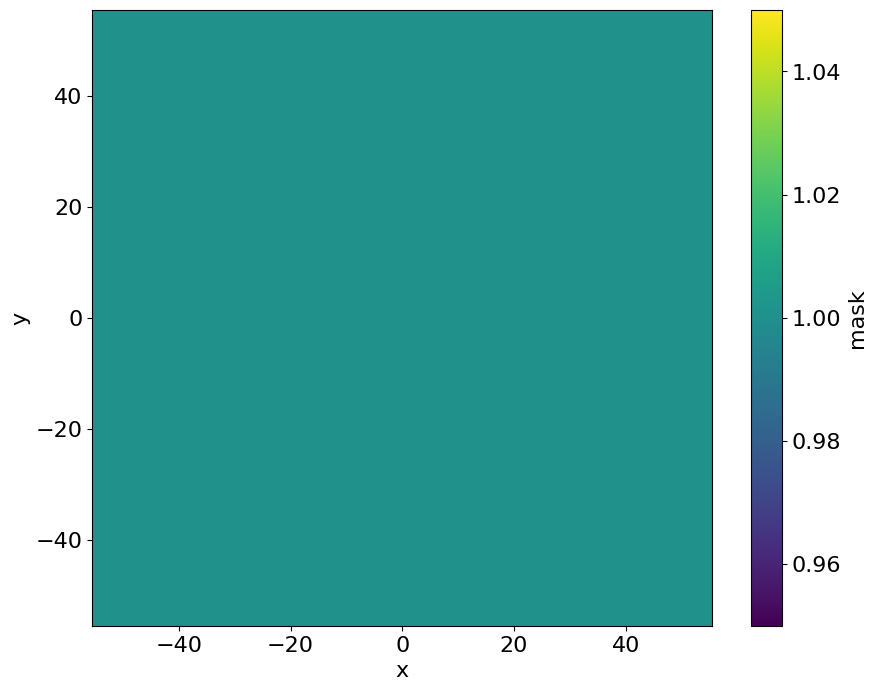

In [11]:
size = 111
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

The default settings for the for `LaPDXYExclusion` are the same as the manually constructed exclusion mask above.

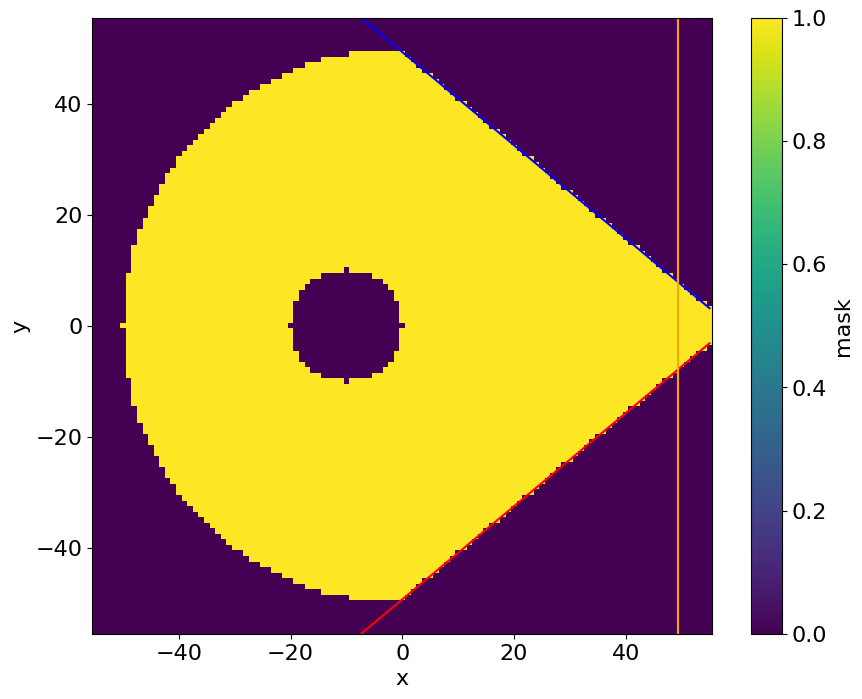

In [12]:
ex = LaPDXYExclusion(ds)
exC = CircularExclusion(ds, radius=10, center=(-10,0), exclude="inside")

ds.mask.plot(x="x", y="y")

colors = ["blue", "red", "orange"]
ii = 0
for subex in ex.composed_exclusions:
    if not isinstance(subex, DividerExclusion):
        continue

    (slope, intercept) = subex.mb
    color = colors[np.mod(ii, len(colors))]
    if np.isinf(slope):
        ylim = plt.gca().get_ylim()
        plt.vlines(intercept, *ylim, color=color)
    else:
        plt.plot(side, slope * side + intercept, color=color)

    ii += 1;

In [16]:
edge_pool = ex._build_edge_pool(ds.mask)

TypeError: LaPDXYExclusion._build_edge_pool() got an unexpected keyword argument 'axis'

In [23]:
edge_points = edge_pool.reshape(-1, 2)

In [26]:
edge_points = np.unique(edge_points, axis=0)

In [28]:
edge_points - ex.insertion_point[np.newaxis, :]

array([[-109.271,   -0.5  ],
       [-109.271,    0.5  ],
       [-108.271,   -9.5  ],
       [-108.271,   -0.5  ],
       [-108.271,    0.5  ],
       [-108.271,    9.5  ],
       [-107.271,  -14.5  ],
       [-107.271,   -9.5  ],
       [-107.271,    9.5  ],
       [-107.271,   14.5  ],
       [-106.271,  -17.5  ],
       [-106.271,  -14.5  ],
       [-106.271,   14.5  ],
       [-106.271,   17.5  ],
       [-105.271,  -19.5  ],
       [-105.271,  -17.5  ],
       [-105.271,   17.5  ],
       [-105.271,   19.5  ],
       [-104.271,  -21.5  ],
       [-104.271,  -19.5  ],
       [-104.271,   19.5  ],
       [-104.271,   21.5  ],
       [-103.271,  -23.5  ],
       [-103.271,  -21.5  ],
       [-103.271,   21.5  ],
       [-103.271,   23.5  ],
       [-102.271,  -25.5  ],
       [-102.271,  -23.5  ],
       [-102.271,   23.5  ],
       [-102.271,   25.5  ],
       [-101.271,  -27.5  ],
       [-101.271,  -25.5  ],
       [-101.271,   25.5  ],
       [-101.271,   27.5  ],
       [-100.2

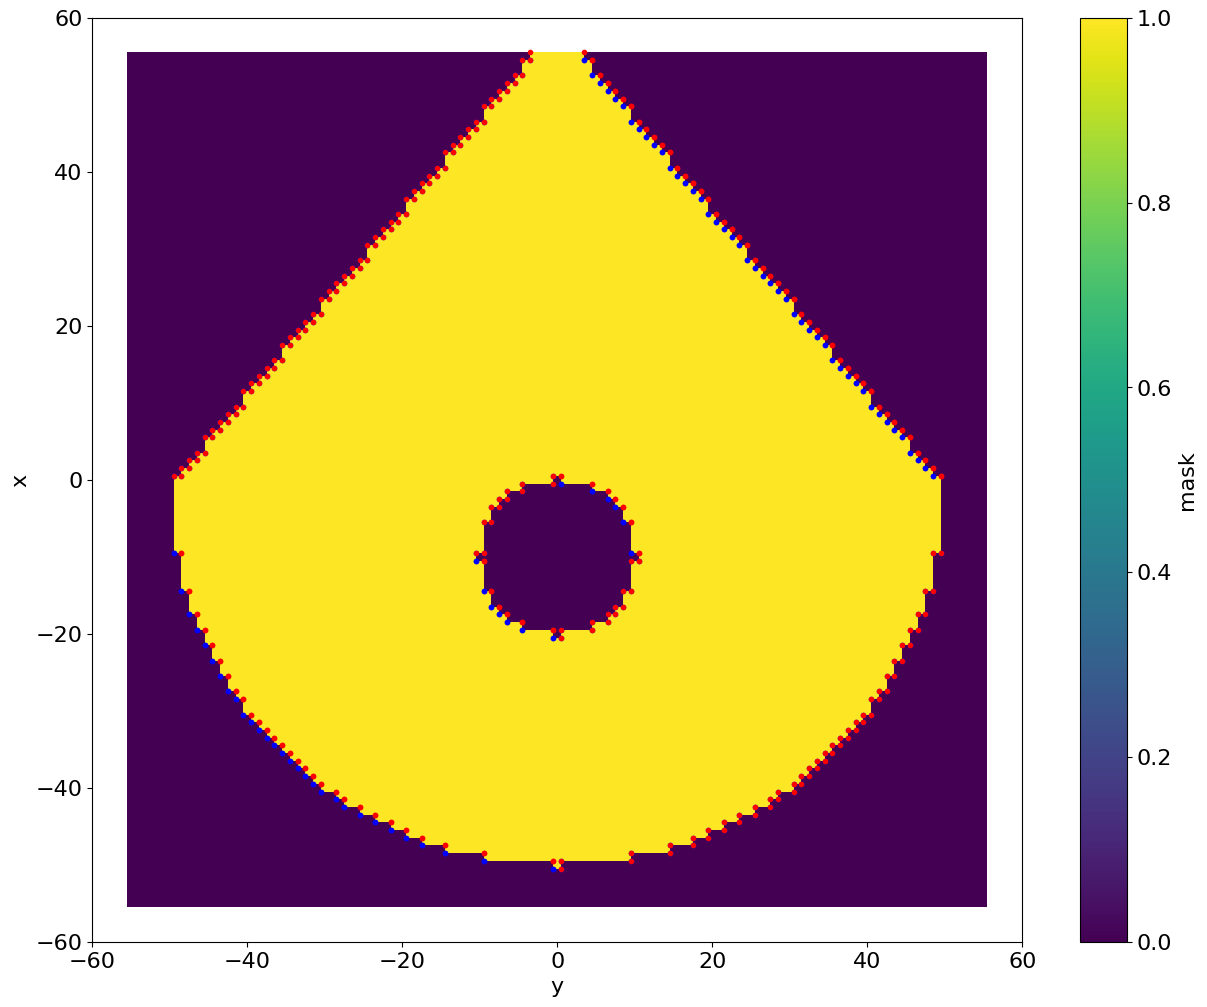

In [14]:
ds.mask.plot(aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(edge_pool[..., 0, 1], edge_pool[..., 0, 0], color="blue", s=3**2)
plt.scatter(edge_pool[..., 1, 1], edge_pool[..., 1, 0], color="red", s=3**2)

## Prototyping: Edge Finding

In [5]:
from bapsf_motion.motion_builder.exclusions import LaPDXYExclusion, CircularExclusion

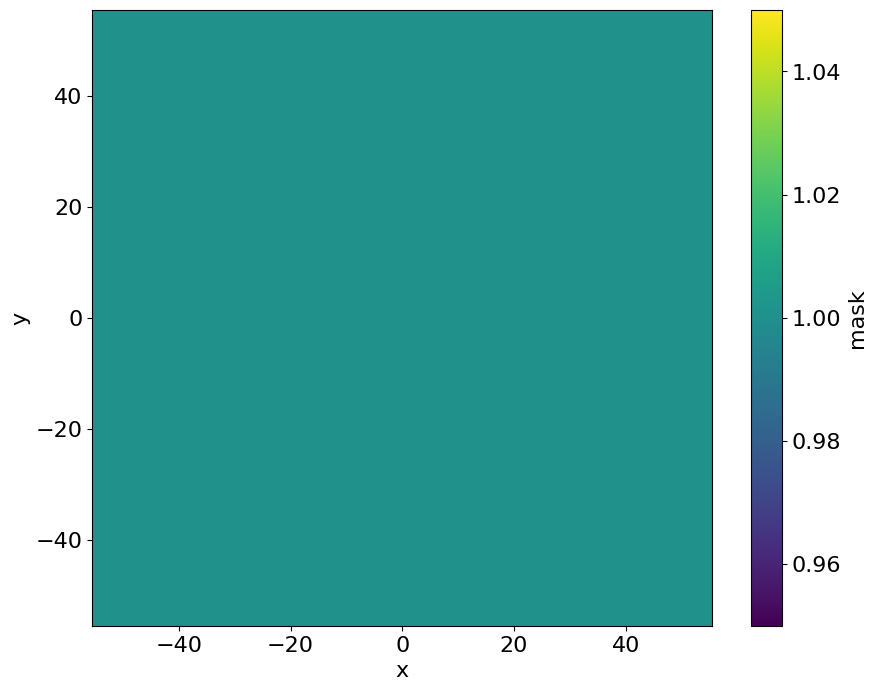

In [6]:
size = 111
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

The default settings for the for `LaPDXYExclusion` are the same as the manually constructed exclusion mask above.

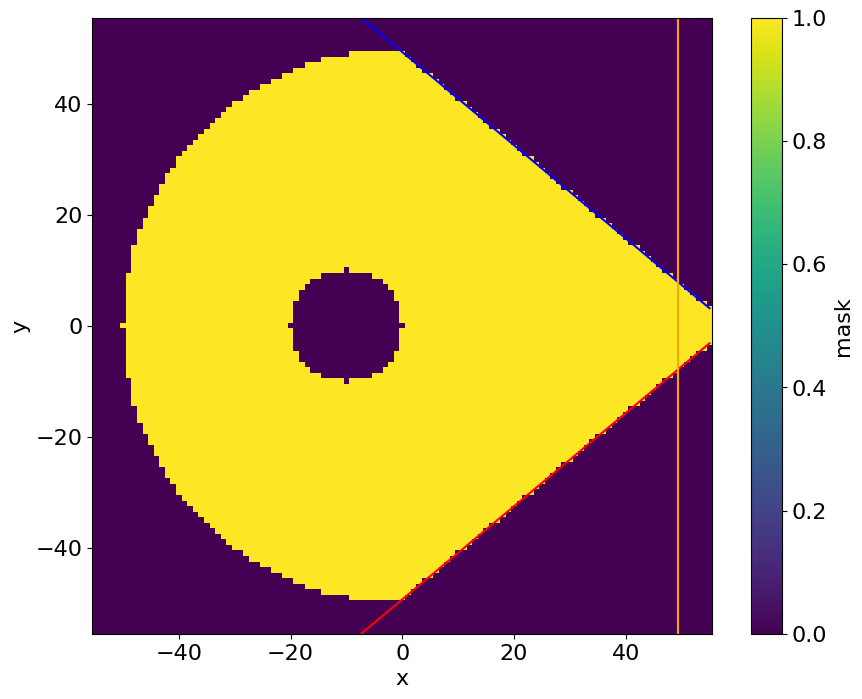

In [7]:
ex = LaPDXYExclusion(ds)
exC = CircularExclusion(ds, radius=10, center=(-10,0), exclude="inside")

ds.mask.plot(x="x", y="y")

colors = ["blue", "red", "orange"]
ii = 0
for subex in ex.composed_exclusions:
    if not isinstance(subex, DividerExclusion):
        continue

    (slope, intercept) = subex.mb
    color = colors[np.mod(ii, len(colors))]
    if np.isinf(slope):
        ylim = plt.gca().get_ylim()
        plt.vlines(intercept, *ylim, color=color)
    else:
        plt.plot(side, slope * side + intercept, color=color)

    ii += 1;

In [42]:
# pool indicess
# index_0 = edge number/count
# index_1 = start and stop edge points (0 = start, 1 = stop)
# index_2 = (x,y) coord of the start/stop edge points
pool = ex._build_edge_pool(ds.mask)
pool.shape

(355, 2, 2)

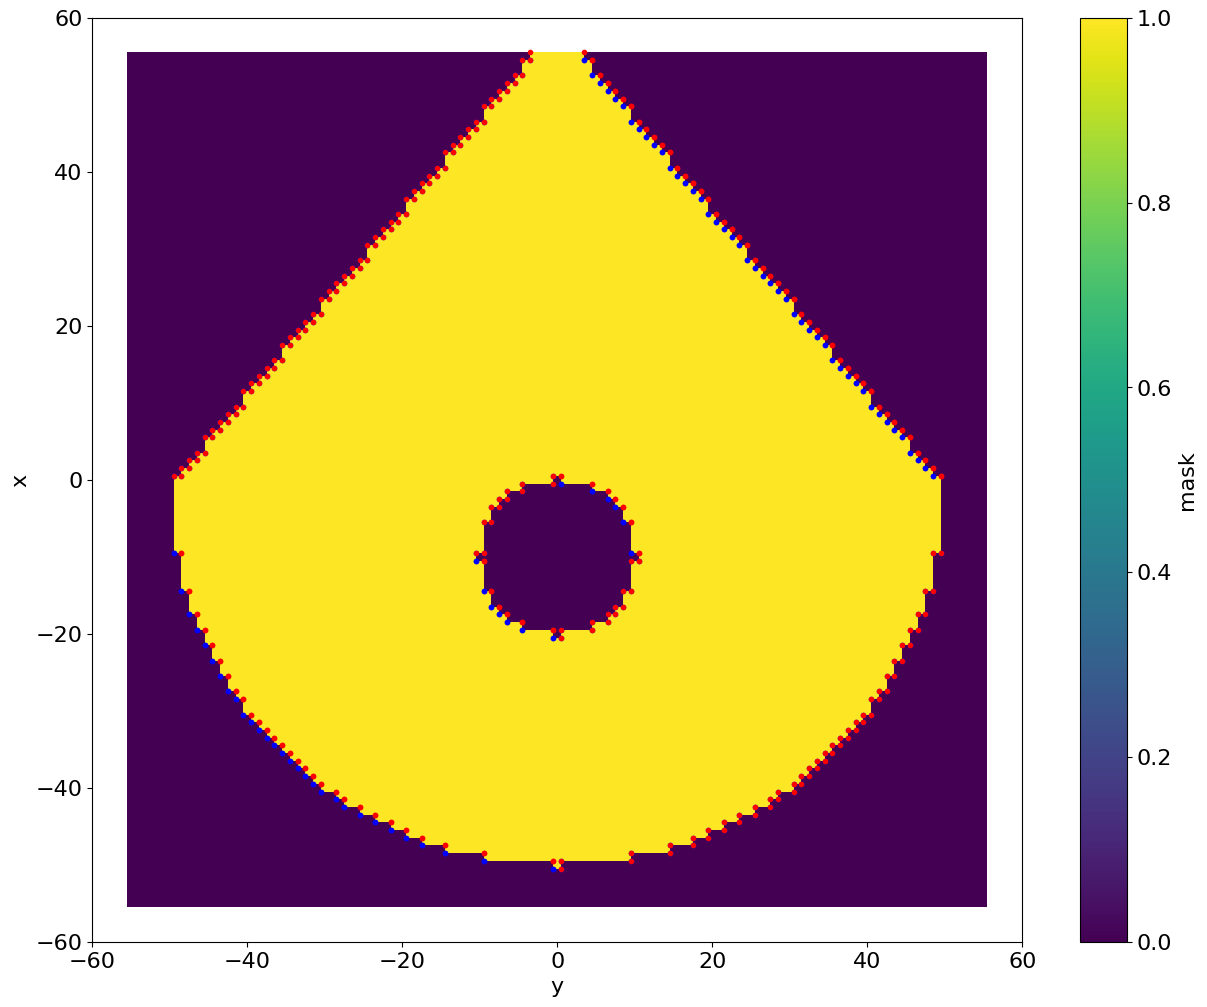

In [43]:
ds.mask.plot(aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(pool[..., 0, 1], pool[..., 0, 0], color="blue", s=3**2)
plt.scatter(pool[..., 1, 1], pool[..., 1, 0], color="red", s=3**2)

In [44]:
# collect unique edge points (i.e. unique (x,y) coords of edge
# segment start and stop locations)
edge_points = edge_pool.reshape(-1, 2)
edge_points = np.unique(edge_points, axis=0)
edge_points.shape

(356, 2)

In [45]:
corner_rays = edge_points - ex.insertion_point
corner_rays.shape

(356, 2)

In [46]:
# sort corner_rays and edge_points corresponding to the ray angle
delta = edge_points - ex.insertion_point[np.newaxis, :]
perp_indices = np.where(delta[..., 0] == 0)[0]
if perp_indices.size > 0:
    delta[perp_indices, 0] = 1  # dx
    delta[perp_indices, 1] = np.inf * (
            delta[perp_indices, 1] / np.abs(delta[perp_indices, 1])
    )  # dy
ray_angles = np.arctan(delta[..., 1] / delta[..., 0])
sort_i = np.argsort(ray_angles)
corner_rays = corner_rays[sort_i]
edge_points = edge_points[sort_i]

(
    corner_rays.shape,
    edge_points.shape,
)

((356, 2), (356, 2))

In [48]:
# compute vectors corresponding to the mask edges
edge_vectors = edge_pool[..., 1, :] - edge_pool[..., 0, :]
edge_vectors.shape

(355, 2)

In [50]:
# determine if a corner_ray intersects an edge that is closer
# to the insertion point
mu_array = (
    np.cross(edge_pool[..., 0, :] - ex.insertion_point, edge_vectors)
    / np.cross(corner_rays, edge_vectors[:, np.newaxis, ...]).swapaxes(0, 1)
)
mu_array.shape

(356, 355)

In [51]:
nu_array = (
    np.cross((ex.insertion_point - edge_pool[..., 0, :])[:, np.newaxis, ...], corner_rays).swapaxes(0, 1)
    / np.cross(edge_vectors[:, np.newaxis, ...], corner_rays).swapaxes(0, 1)
)
nu_array.shape

(356, 355)

In [58]:
mu_condition = np.logical_and(mu_array > 0, mu_array < 1)
nu_condition = np.logical_and(nu_array >= 0, nu_array < 1)
intersection_mask = np.logical_and(mu_condition, nu_condition)
intersection_mask.shape

(356, 355)

In [9]:
it = np.nditer(ds.mask, flags=["multi_index"])
for x in it:
    pass
    # print(it.multi_index)
type(x)

numpy.ndarray

In [10]:
mask_edges = xr.DataArray(
    data = -np.ones((size, size, 4), dtype=np.int32),
    coords = {**ds.coords, "edge": ["top", "right", "bottom", "left"]}
)

# mask_edges[ix, iy].loc["north"] = 5
# mask_edges[ix, iy].loc["north"]

In [11]:
mres = (
    np.average(np.diff(ds.x)),
    np.average(np.diff(ds.y)),
)
edge_pool = None

def add_to_edge_pool(edge, _pool):
    if _pool is None:
        _pool = np.array(edge)[np.newaxis, ...]
    else:
        _pool = np.concatenate(
            (_pool, np.array(edge)[np.newaxis, ...]),
            axis=0,
        )

    return _pool.shape[0] - 1, _pool

# edge_pool stores the actual edge information
# mask_edges stores the edge ID for each mask cell

for ix, row in enumerate(ds.mask):
    for iy, m in enumerate(row):
        # ix = np.where(ds.x == m.x)[0][0]
        # iy = np.where(ds.y == m.y)[0][0]
        index_top = (ix, iy+1)
        index_bottom = (ix, iy-1)
        index_right = (ix+1, iy)
        index_left = (ix-1, iy)

        if (
            bool(m)
            and (
                ix not in (0, size-1) 
                or iy not in (0, size-1)
            )
        ):
            # only find edges for exluded regions and mspace boundary
            # print(f"Continue ({ix}, {iy})")
            continue
        
        # Look at Bottom
        need_edge = (
            True
            if iy == 0 or bool(m != ds.mask[index_bottom])
            else False
        )
        
        if need_edge:
            if (
                ix == 0 
                or bool(m != ds.mask[index_left])
                or mask_edges[index_left].loc["bottom"] == -1
            ):
                # need new edge
                _edge = [
                    ds.x[ix] - 0.5 * mres[0],  # start x
                    ds.y[iy] - 0.5 * mres[1],  # start y
                    np.nan,  # stop x
                    np.nan,  # stop y
                ]
                eid, edge_pool = add_to_edge_pool(_edge, edge_pool)
            else:
                # continue existing edge
                eid  = mask_edges[index_left].loc["bottom"]

            mask_edges[ix, iy].loc["bottom"] = eid

            if (
                ix == size-1 
                or bool(m != ds.mask[index_right])
                or bool(m == ds.mask[index_right[0], index_bottom[1]])
            ):
                # edge ends
                edge_pool[eid, 2:] = [
                    ds.x[ix] + 0.5 * mres[0],  # stop x
                    ds.x[iy] - 0.5 * mres[1],  # stop y
                ]

        # Look at Top
        need_edge = (
            True
            if iy == size-1 or bool(m != ds.mask[index_top])
            else False
        )
        
        if need_edge:
            if (
                ix == 0 
                or bool(m != ds.mask[index_left])
                or mask_edges[index_left].loc["top"] == -1
            ):
                # need new edge
                _edge = [
                    ds.x[ix] - 0.5 * mres[0],  # start x
                    ds.y[iy] + 0.5 * mres[1],  # start y
                    np.nan,  # stop x
                    np.nan,  # stop y
                ]
                eid, edge_pool = add_to_edge_pool(_edge, edge_pool)
            else:
                # continue existing edge
                eid  = mask_edges[index_left].loc["top"]

            mask_edges[ix, iy].loc["top"] = eid

            if (
                ix == size-1 
                or bool(m != ds.mask[index_right])
                or bool(m == ds.mask[index_right[0], index_bottom[1]])
            ):
                # edge ends
                edge_pool[eid, 2:] = [
                    ds.x[ix] + 0.5 * mres[0],  # stop x
                    ds.x[iy] + 0.5 * mres[1],  # stop y
                ]

        # Look at Right
        need_edge = (
            True
            if ix == size-1 or bool(m != ds.mask[index_right])
            else False
        )
        
        if need_edge:
            if (
                iy == 0 
                or bool(m != ds.mask[index_bottom])
                or mask_edges[index_bottom].loc["right"] == -1
            ):
                # need new edge
                _edge = [
                    ds.x[ix] + 0.5 * mres[0],  # start x
                    ds.y[iy] - 0.5 * mres[1],  # start y
                    np.nan,  # stop x
                    np.nan,  # stop y
                ]
                eid, edge_pool = add_to_edge_pool(_edge, edge_pool)
            else:
                # continue existing edge
                eid  = mask_edges[index_bottom].loc["right"]

            mask_edges[ix, iy].loc["right"] = eid

            if (
                iy == size-1 
                or bool(m != ds.mask[index_top])
                or bool(m == ds.mask[index_top[0], index_right[1]])
            ):
                # edge ends
                edge_pool[eid, 2:] = [
                    ds.x[ix] + 0.5 * mres[0],  # stop x
                    ds.x[iy] + 0.5 * mres[1],  # stop y
                ]

        # Look at Left
        need_edge = (
            True
            if ix == 0 or bool(m != ds.mask[index_left])
            else False
        )
        
        if need_edge:
            if (
                iy == 0 
                or bool(m != ds.mask[index_bottom])
                or mask_edges[index_bottom].loc["left"] == -1
            ):
                # need new edge
                _edge = [
                    ds.x[ix] - 0.5 * mres[0],  # start x
                    ds.y[iy] - 0.5 * mres[1],  # start y
                    np.nan,  # stop x
                    np.nan,  # stop y
                ]
                eid, edge_pool = add_to_edge_pool(_edge, edge_pool)
            else:
                # continue existing edge
                eid  = mask_edges[index_bottom].loc["left"]

            mask_edges[ix, iy].loc["left"] = eid

            if (
                iy == size-1 
                or bool(m != ds.mask[index_top])
                or bool(m == ds.mask[index_top[0], index_right[1]])
            ):
                # edge ends
                edge_pool[eid, 2:] = [
                    ds.x[ix] - 0.5 * mres[0],  # stop x
                    ds.x[iy] + 0.5 * mres[1],  # stop y
                ]

edge_pool

array([[-55.5, -55.5,  55.5, -55.5],
       [-55.5, -55.5, -55.5,  55.5],
       [-55.5,  55.5,  55.5,  55.5],
       ...,
       [ 54.5,   3.5,  55.5,   3.5],
       [ 55.5,   3.5,  55.5,  55.5],
       [ 54.5,   3.5,  54.5,   4.5]])

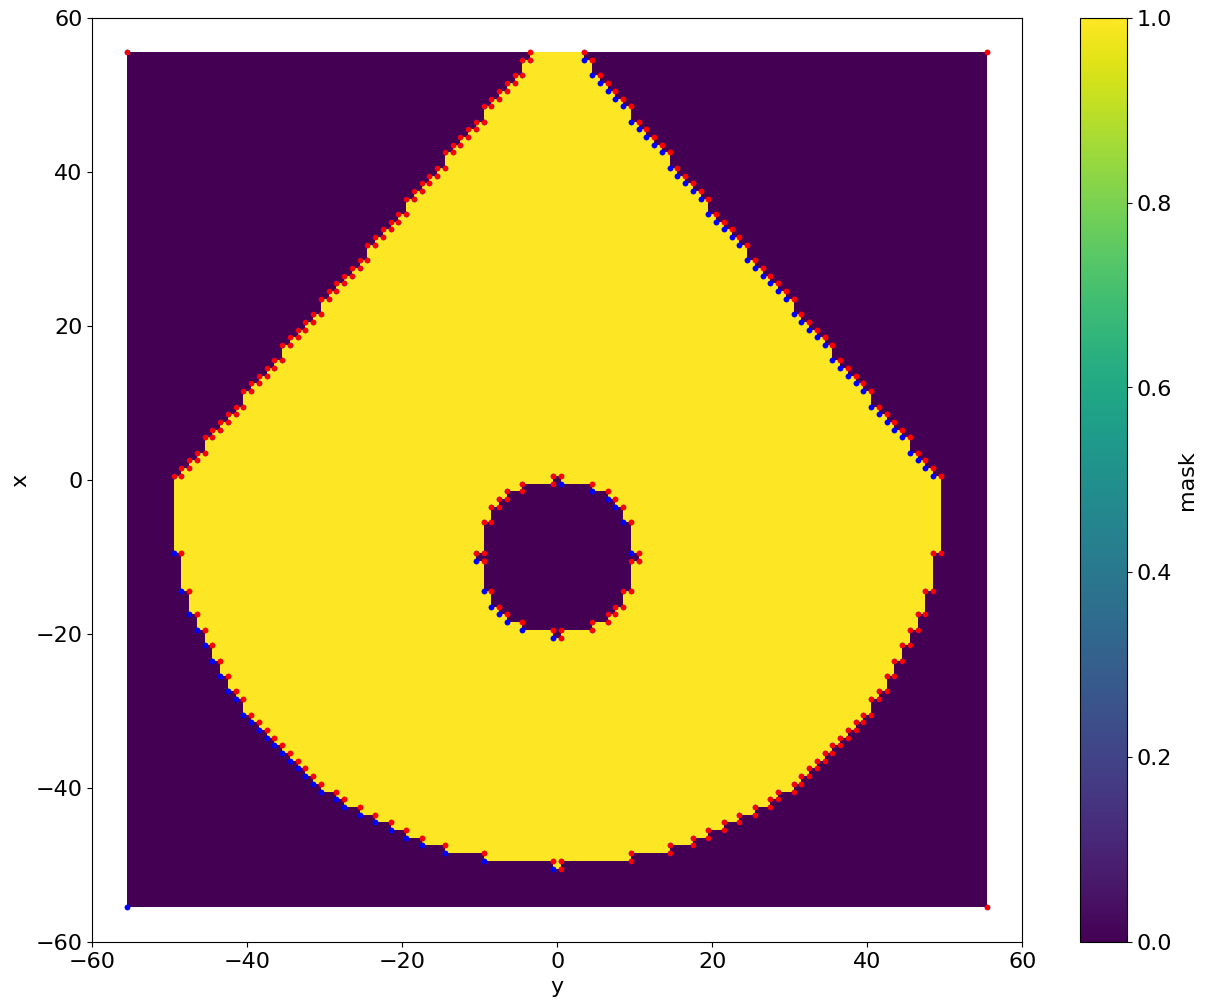

In [12]:
ds.mask.plot(aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(edge_pool[...,1], edge_pool[...,0], color="blue", s=3**2)
plt.scatter(edge_pool[...,3], edge_pool[...,2], color="red", s=3**2)

# lines = edge_pool.reshape(-1, 2, 2).reshape(-1, 2)
# plt.plot(*lines, c="k");
# plt.scatter(ds.x[0], ds.y[0])

# edge_points = edge_pool.reshape(-1, 2, 2).reshape(-1, 2)
# edge_points = np.unique(edge_points, axis=0)
# plt.scatter(edge_points[...,1], edge_points[..., 0])

In [527]:
def add_to_ep(edge, _pool):
    if _pool is None:
        _pool = np.array(edge)[np.newaxis, ...]
    else:
        _pool = np.concatenate(
            (_pool, np.array(edge)[np.newaxis, ...]),
            axis=0,
        )

    return _pool.shape[0] - 1, _pool

def build_edge_pool(_ds: xr.Dataset):
    # edge_pool.shape == (N, 2, 2)
    # index_1 == N == number of edges
    # index_2 == 2 == edge point 0 = start, 1 = stop
    # index_3 == 2 == coordingate (0, 1) = (x, y)

    mres = (
    np.average(np.diff(ds.x)),
    np.average(np.diff(ds.y)),
    )
    ep = None

    return ep

# vertical edges
vedge_indices = np.where(np.diff(ds.mask, axis=0))
xx = np.unique(vedge_indices[0])
# mask = vedge_indices[0] == 7
yy_mask = np.diff(vedge_indices[1]) !=  1
(
    xx,
    yy_mask,
)


ep = None
for ix in xx:
    _mask = vedge_indices[0] == ix
    yy = vedge_indices[1][_mask]

    x = ds.x[ix] + 0.5*mres[0]
    
    if yy.size == 1:
        iy = yy[0]
        edge = np.array(
            [
                [x, ds.y[iy] - 0.5*mres[1]],
                [x, ds.y[iy] + 0.5*mres[1]],
            ]
        )
        eid, ep = add_to_ep(edge, ep)
    else:
        
        jumps = np.where(np.diff(yy) != 1)[0]
        
        starts = np.array([0])
        starts = np.concatenate((starts, jumps+1))
        starts = yy[starts]
        
        stops = np.concatenate((jumps, [yy.size-1]))
        stops = yy[stops]

        for iy_start, iy_stop in zip(starts, stops):
            edge = np.array(
                [
                    [x, ds.y[iy_start] - 0.5*mres[1]],
                    [x, ds.y[iy_stop] + 0.5*mres[1]],
                ]
            )
            eid, ep = add_to_ep(edge, ep)

# horizontal edges
hedge_indices = np.where(np.diff(ds.mask, axis=1))
yy = np.unique(hedge_indices[1])
xx_mask = np.diff(hedge_indices[0]) !=  1

for iy in yy:
    _mask = hedge_indices[1] == iy
    xx = hedge_indices[0][_mask]

    y = ds.y[iy] + 0.5*mres[1]
    
    if xx.size == 1:
        ix = xx[0]
        edge = np.array(
            [
                [ds.x[ix] - 0.5*mres[0], y],
                [ds.x[ix] + 0.5*mres[0], y],
            ]
        )
        eid, ep = add_to_ep(edge, ep)
    else:
        
        jumps = np.where(np.diff(xx) != 1)[0]
        
        starts = np.array([0])
        starts = np.concatenate((starts, jumps+1))
        starts = xx[starts]
        
        stops = np.concatenate((jumps, [xx.size-1]))
        stops = xx[stops]

        for ix_start, ix_stop in zip(starts, stops):
            edge = np.array(
                [
                    [ds.x[ix_start] - 0.5*mres[0], y],
                    [ds.x[ix_stop] + 0.5*mres[0], y],
                ]
            )
            eid, ep = add_to_ep(edge, ep)

# TODO: add perimeter edges

# (
#     ep[0,0,:],
#     ep[0,1,:],
#     ep.shape
# )
ep = ep.reshape(-1, 4)
edge_pool = ep
# (
#     ep.shape,
#     edge_pool.shape
# )

In [528]:
edge_points = edge_pool.reshape(-1, 2, 2).reshape(-1, 2)
edge_points = np.unique(edge_points, axis=0)
edge_points.shape

(356, 2)

In [529]:
insertion_point = ex.insertion_point
insertion_point

array([58.771,  0.   ])

In [530]:
dy = (edge_points[..., 1] - insertion_point[1])
dx = (edge_points[..., 0] - insertion_point[0])

perp = np.where(dx == 0)[0]
if perp.size > 0:
    dy[perp] = np.inf * dy[perp] / np.abs(dy[perp])
    dx[perp] = 1.

ray_angles = np.arctan(dy / dx)

In [531]:
edge_points = np.concatenate(
    (edge_points, ray_angles[..., np.newaxis]),
    axis=1,
)
sort_i = np.argsort(edge_points[..., 2])
edge_points = edge_points[sort_i, ...]
edge_points.shape

(356, 3)

In [532]:
edge_vectors = edge_pool[..., 2:] - edge_pool[..., :2]
ray_vectors = edge_points[..., :2] - insertion_point
ray_vector = ray_vectors[0, ...]
(
    ray_vector,
    edge_vectors.shape,
)

(array([-3.271,  3.5  ]), (355, 2))

In [533]:
# mu_array = edge_pool[...,:2] - insertion_point
# mu_array = (
#     np.cross(edge_pool[...,:2] - insertion_point, edge_vectors) 
#     / np.cross(ray_vectors, edge_vectors)
# )
mu_array = (
    np.cross(edge_pool[...,:2] - insertion_point, edge_vectors) 
    / np.cross(ray_vectors, edge_vectors[:, np.newaxis, ...]).swapaxes(0, 1)
)
mu_array.shape

(356, 355)

In [534]:
# nu_array = (
#     np.cross(insertion_point - edge_pool[..., :2], ray_vectors)
#     / np.cross(edge_vectors, ray_vectors)
# )
nu_array = (
    np.cross((insertion_point - edge_pool[..., :2])[:, np.newaxis, ...], ray_vectors).swapaxes(0, 1)
    / np.cross(edge_vectors[:, np.newaxis, ...], ray_vectors).swapaxes(0, 1)
)
nu_array.shape

(356, 355)

In [535]:
c1 = mu_array > 0
c2 = mu_array < 1
c3 = nu_array >= 0
c4 = nu_array < 1

m1 = np.logical_and(c1, c2)
m2 = np.logical_and(c3, c4)
m3 = np.logical_and(m1, m2)
(
    np.count_nonzero(m1),
    np.count_nonzero(m2),
    np.count_nonzero(m3),
    m3.shape,
    np.count_nonzero(m3[50,...])
)


(46410, 9071, 6434, (356, 355), 76)

In [536]:
ii = 50

(
    ray_vectors[ii, ...],
    edge_points[ii, ...],
)

(array([-53.271,  44.5  ]), array([ 5.5       , 44.5       , -0.69592804]))

In [537]:
min_mu = np.min(mu_array[ii, m3[ii, ...]])
pt = insertion_point + min_mu * ray_vectors[ii, ...]

(
    min_mu,
    pt,
)

(0.07865168539325842, array([54.58114607,  3.5       ]))

In [538]:
adjusted_mu_array = np.nanmin(np.where(m3, mu_array, 1), axis=1)
end_pts = insertion_point + adjusted_mu_array[..., np.newaxis] * ray_vectors[...,:2]
# end_pts = np.unique(end_pts, axis=0)

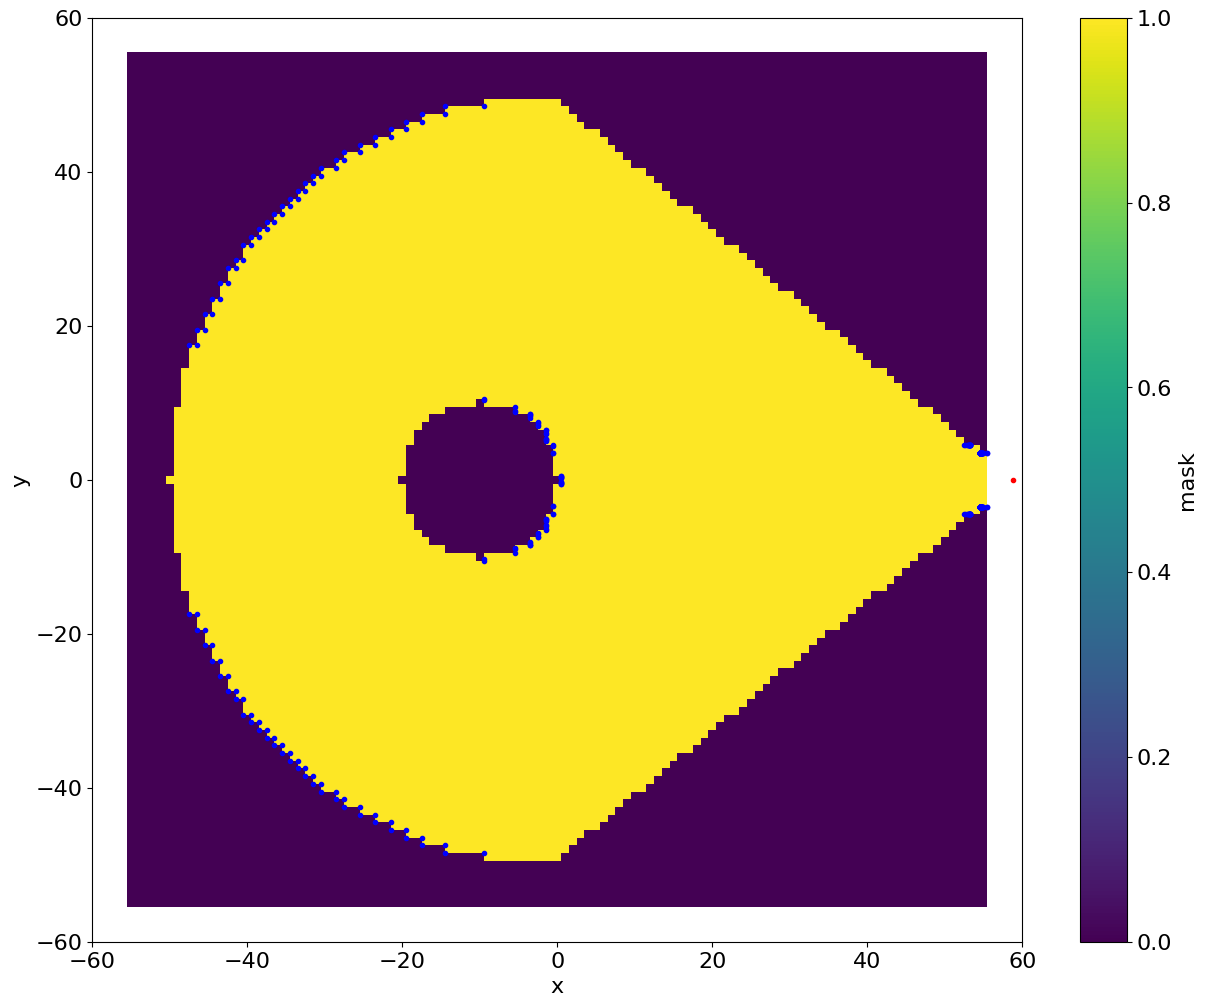

In [539]:
ds.mask.plot(x="x", y="y", aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(*insertion_point, color="red", s=3**2)
plt.scatter(end_pts[..., 0], end_pts[..., 1], color="blue", s=3**2)
# plt.scatter(edge_pool[...,3], edge_pool[...,2], color="red", s=3**2)

In [540]:
corner_mask = np.where(adjusted_mu_array == 1)[0]
# corner_pts = end_pts[corner_mask]
# corner_pts.shape
corner_rays = ray_vectors[corner_mask, ...]
# corner_ray_angles = edge_points[corner_mask, 2]
(
    corner_rays.shape,
    # corner_ray_angles.shape,
)

((124, 2),)

In [541]:
# corner_ray_angles

angles = np.arcsin(corner_rays[..., 1] / np.linalg.norm(corner_rays, axis=1))
corner_ray_angles = np.where(corner_rays[..., 0] >=0, angles, np.pi - angles)
# corner_ray_angles = angles
corner_ray_angles.shape

(124,)

In [542]:
fan_plus = np.linalg.norm(corner_rays, axis=1) * [np.cos(corner_ray_angles + .00001), np.sin(corner_ray_angles + .00001)]
fan_plus = fan_plus.swapaxes(0,1)

fan_minus = np.linalg.norm(corner_rays, axis=1) * [np.cos(corner_ray_angles - .00001), np.sin(corner_ray_angles - .00001)]
fan_minus = fan_minus.swapaxes(0,1)

fan_rays = np.concatenate(
    (fan_plus, fan_minus),
    axis=0,
)
(
    fan_plus.shape,
    fan_minus.shape,
    fan_rays.shape,
)

((124, 2), (124, 2), (248, 2))

In [543]:
mu_array = (
    np.cross(edge_pool[...,:2] - insertion_point, edge_vectors) 
    / np.cross(fan_rays, edge_vectors[:, np.newaxis, ...]).swapaxes(0, 1)
)
mu_array.shape

(248, 355)

In [544]:
mu_array[0,...]

array([ 33.40563461,  33.09992097,  33.09992097,  32.79420734,
        32.79420734,  32.4884937 ,  32.4884937 ,  32.18278007,
        32.18278007,  31.87706643,  31.87706643,  31.5713528 ,
        31.5713528 ,  31.26563916,  31.26563916,  30.95992553,
        30.95992553,  30.65421189,  30.65421189,  30.34849826,
        30.34849826,  30.04278462,  30.04278462,  29.73707099,
        29.73707099,  29.43135735,  29.43135735,  29.12564372,
        29.12564372,  28.81993008,  28.81993008,  28.51421645,
        28.51421645,  28.20850281,  28.20850281,  27.90278918,
        27.90278918,  27.59707554,  27.59707554,  27.29136191,
        27.29136191,  26.67993464,  26.67993464,  26.374221  ,
        26.374221  ,  25.76279373,  25.76279373,  25.15136646,
        25.15136646,  24.53993919,  24.53993919,  24.23422556,
        23.92851192,  23.92851192,  23.92851192,  23.92851192,
        23.62279829,  23.62279829,  23.31708465,  23.31708465,
        23.31708465,  23.31708465,  23.01137102,  23.01

In [545]:
nu_array = (
    np.cross((insertion_point - edge_pool[..., :2])[:, np.newaxis, ...], fan_rays).swapaxes(0, 1)
    / np.cross(edge_vectors[:, np.newaxis, ...], fan_rays).swapaxes(0, 1)
)
nu_array.shape

(248, 355)

In [546]:
c1 = mu_array > 0
# c2 = mu_array < 1
c3 = nu_array >= 0
c4 = nu_array < 1

# m1 = np.logical_and(c1, c2)
m2 = np.logical_and(c3, c4)
m3 = np.logical_and(c1, m2)
(
    np.count_nonzero(m1),
    np.count_nonzero(m2),
    np.count_nonzero(m3),
    m3.shape,
    np.count_nonzero(m3[1,...])
)


(46410, 466, 466, (248, 355), 35)

In [547]:
ii = 1
# m3[ii, ...]
mu_array[ii, m3[ii, ...]]

array([ 8.72645623,  7.32164452,  7.08750923,  6.15096809,  5.91683281,
        5.68269752,  4.74615638,  4.51202109,  4.27788581,  3.57547995,
        3.34134466,  3.10720938,  2.87307409,  2.17066823,  1.93653295,
        1.70239766,  1.46826238,  1.28572998,  1.57144775,  1.85716552,
        2.14288329,  2.71431884,  3.00003661,  3.28575438,  3.57147215,
        4.1429077 ,  4.42862547,  4.71434324,  5.57149656,  5.85721433,
        6.1429321 ,  7.00008542,  7.28580319,  8.71439206, 14.14302973])

In [548]:
adjusted_mu_array = np.nanmin(np.where(m3, mu_array, np.inf), axis=1)
fan_end_pts = insertion_point + adjusted_mu_array[..., np.newaxis] * fan_rays[...,:2]
# fan_end_pts = insertion_point - 1 * fan_rays[...,:2]
# fan_end_pts = insertion_point + fan_plus
inf_mask = np.logical_not(np.any(np.isinf(fan_end_pts), axis=1))

fan_end_pts = fan_end_pts[inf_mask, ...]
fan_end_pts.shape

(246, 2)

''

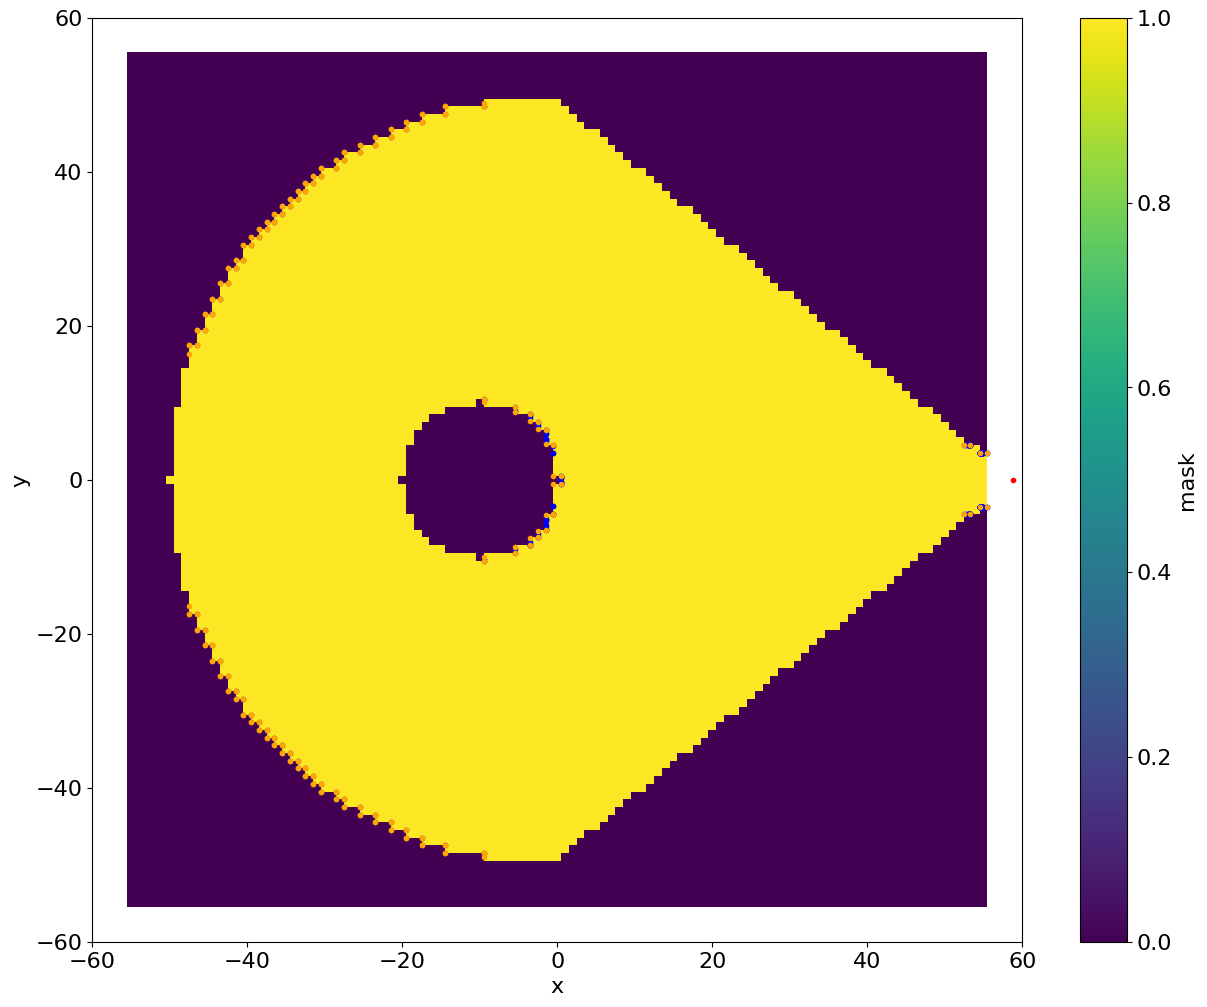

In [549]:
ds.mask.plot(x="x", y="y", aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(*insertion_point, color="red", s=3**2)
plt.scatter(end_pts[..., 0], end_pts[..., 1], color="blue", s=3**2)
plt.scatter(fan_end_pts[..., 0], fan_end_pts[..., 1], color="orange", s=3**2)
# plt.scatter(edge_pool[...,3], edge_pool[...,2], color="red", s=3**2)
;

In [550]:
# build triangles
all_end_pts = np.concatenate(
    (end_pts, fan_end_pts),
    axis=0,
)

def sort_array_by_angle(_arr, _ip):
    _arr2 = np.zeros_like(_arr)
    _arr2[..., 1] = _arr[..., 1] - _ip[1]
    _arr2[..., 0] = _arr[..., 0] - _ip[0]

    angles = np.arcsin(_arr2[..., 1] / np.linalg.norm(_arr2, axis=1))
    # andgles = np.arcsin(dy, np.linalg.norm([dx, dy], axis=0))
    
    sort_i = np.argsort(angles)
    return _arr[sort_i]

# angles = np.arcsin(all_end_pts[..., 1] / np.linalg.norm(all_end_pts, axis=1))
# angles = np.where(all_end_pts[..., 0] >0, angles, np.pi - angles)
# angles = np.arctan(all_end_pts[..., 1] / all_end_pts[..., 0])
# sort_i = np.argsort(angles)
# angles[sort_i]
# np.linalg.norm(all_end_pts, axis=1)
# np.any(np.isinf(fan_end_pts))
# all_end_pts = all_end_pts[sort_i]
all_end_pts = sort_array_by_angle(all_end_pts, insertion_point)
all_end_pts.shape

(602, 2)

In [551]:
def filter_close_points(_arr):
    _mask = np.all(
        np.isclose(
            all_end_pts,
            np.roll(all_end_pts, -1, axis=0),
            atol=.95*mres[0],
        ),
        axis=1,
    )
    _mask = np.roll(np.logical_not(_mask), 1)
    _mask[0] = True
    _mask[-1] = True

    return _arr[_mask, :]

# m_aep = np.all(np.isclose(all_end_pts, np.roll(all_end_pts, -1, axis=0), atol=.1*mres[0]), axis=1)
# m_aep = np.roll(np.logical_not(m_aep), 1)
# m_aep[0] = True
# m_aep[-1] = True

# all_end_pts = all_end_pts[m_aep, :]
all_end_pts = filter_close_points(all_end_pts)
all_end_pts = sort_array_by_angle(all_end_pts, insertion_point)
all_end_pts

array([[ 55.5       ,  -3.5       ],
       [ 53.27960227,  -4.5       ],
       [ -9.5       , -48.98947763],
       [-14.49840809, -48.5       ],
       [-14.5       , -47.50104065],
       [-17.49830034, -47.5       ],
       [-17.5       , -46.50104621],
       [-19.49821754, -46.5       ],
       [-19.5       , -45.50104721],
       [-21.49812889, -45.5       ],
       [-21.5       , -44.50104941],
       [-23.49803402, -44.5       ],
       [-23.5       , -43.50105272],
       [-25.49793249, -43.5       ],
       [-25.5       , -42.50105705],
       [-27.49782382, -42.5       ],
       [-27.5       , -41.50106235],
       [-28.49774981, -41.5       ],
       [-28.5       , -40.50106066],
       [-30.49762732, -40.5       ],
       [-30.5       , -39.50106749],
       [-31.49754206, -39.5       ],
       [-31.5       , -38.50106691],
       [-32.49745132, -38.5       ],
       [-32.5       , -37.50106679],
       [-33.49735468, -37.5       ],
       [-33.5       , -36.5010671 ],
 

In [552]:
_arr = all_end_pts
angles = np.arcsin(_arr[..., 1] / np.linalg.norm(_arr, axis=1))
angles

array([-0.06297966, -0.08426011, -1.37925447, -1.28031574, -1.27452409,
       -1.21783745, -1.21085522, -1.17374948, -1.16591287, -1.1294009 ,
       -1.12073178, -1.0849647 , -1.07549522, -1.04061593, -1.0303878 ,
       -0.99652759, -0.98559102, -0.96905734, -0.9576013 , -0.92536022,
       -0.91328115, -0.89763902, -0.8850804 , -0.86974355, -0.85671971,
       -0.84171593, -0.82824366, -0.8135995 , -0.79969794, -0.78543842,
       -0.77112891, -0.7572773 , -0.74258315, -0.72916072, -0.71410703,
       -0.70113287, -0.68574623, -0.67323707, -0.65754533, -0.64551545,
       -0.61322509, -0.60181871, -0.58523515, -0.57434781, -0.54043813,
       -0.53025947, -0.49533039, -0.48591047, -0.45009341, -0.4414738 ,
       -0.40491182, -0.39712453, -0.3599689 , -0.35303566, -0.33142211,
       -0.83535656, -1.04600056, -1.18018928, -1.24904577, -1.34399748,
       -1.46013911, -1.42694248, -0.79448788, -0.78539816,  0.79448788,
        1.42510687,  1.45828772,  1.25407073,  1.20913336,  1.14

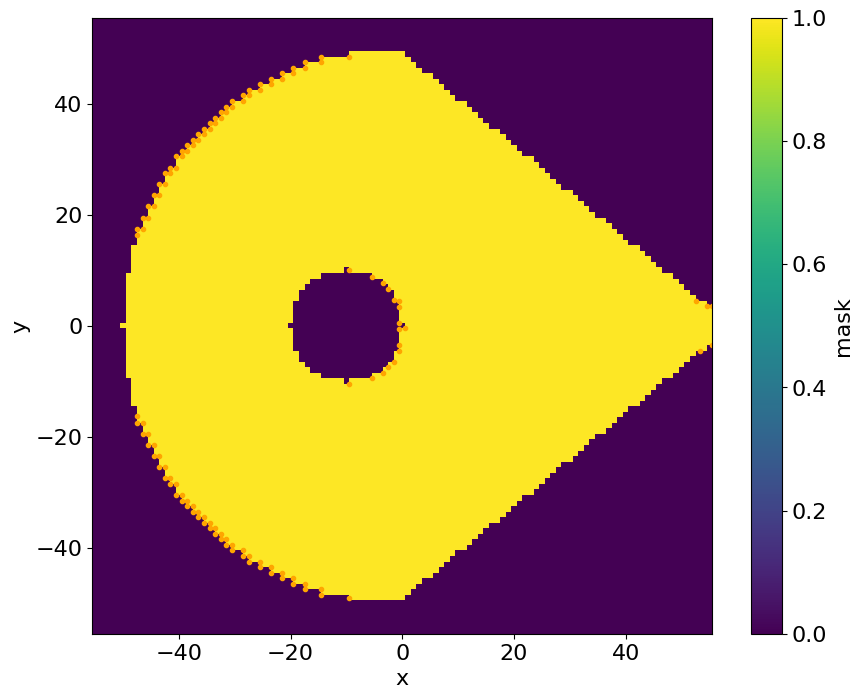

In [553]:
ds.mask.plot(x="x", y="y")
plt.scatter(all_end_pts[..., 0], all_end_pts[..., 1], color="orange", s=3**2);

In [554]:
triangles = np.zeros((all_end_pts.shape[0]-1, 3, 2))
triangles[..., 0, :] = insertion_point
triangles[..., 1, :] = all_end_pts[:-1,:]
triangles[..., 2, :] = all_end_pts[1:,:]
# triangles = triangles[48,...][np.newaxis, ...]
triangles.shape

(127, 3, 2)

In [555]:
all_pts = np.zeros((ds.x.size, ds.y.size, 2))
all_pts[..., 0] = np.repeat(ds.x.values[..., np.newaxis], ds.y.size, axis=1)
all_pts[..., 1] = np.repeat(ds.y.values[np.newaxis, ...], ds.x.size, axis=0)
# all_pts = all_pts.reshape(-1, 2)
all_pts.shape

(111, 111, 2)

In [556]:
# nom = (
#     np.cross(
#         all_pts[..., None, :],
#         triangles[None, None, :, 1, :] - triangles[None, None, :, 0, :]
#     )
#     - np.cross(triangles[:, 0, :], triangles[:, 1, :])[None, None, :]
# )
nom = np.cross(
    all_pts[:, :, None, :] - triangles[None, None, :, 0, :],
    (triangles[:, 1, :] - triangles[:, 0, :])[None, None, :, :],
)
# denom = np.cross(
#     triangles[..., 2, :] - triangles[..., 0, :],
#     triangles[..., 1, :] - triangles[..., 0, :],
# )
denom = np.cross(
    triangles[:, 2, :] - triangles[:, 0, :],
    triangles[:, 1, :] - triangles[:, 0, :]
)

lambda_3 = nom / denom[None, None, ...]

(
    nom.shape,
    denom.shape,
    lambda_3.shape,
    all_pts.shape,
)

((111, 111, 127), (127,), (111, 111, 127), (111, 111, 2))

In [557]:
ml3_1 = lambda_3 >= 0
ml3_2 = lambda_3 < 1
ml3 = np.logical_and(ml3_1, ml3_2)
np.count_nonzero(ml3)

13124

In [558]:
# nom = all_pts[:, :, None, :] - triangles[None, None, :, 0, :] - (triangles[:, 2, :] - triangles[:, 0, :])[None, None, :, :] * lambda_3[:, :, :, None]
# denom = triangles[:, 1, :] - triangles[:, 0, :]

nom  = np.cross(
    all_pts[:, :, None, :] - triangles[None, None, :, 0, :],
    (triangles[:, 2, :] - triangles[:, 0, :])[None, None, :, :],
)
denom = np.cross(
    triangles[:, 1, :] - triangles[:, 0, :],
    triangles[:, 2, :] - triangles[:, 0, :]
)

lambda_2 = nom / denom[None, None, :]

(
    nom.shape,
    denom.shape,
    lambda_2.shape,
)

((111, 111, 127), (127,), (111, 111, 127))

In [559]:
ml2_1 = lambda_2 >= 0
ml2_2 = lambda_2 <= 1
ml2 = np.logical_and(ml2_1, ml2_2)
np.count_nonzero(ml2)

12679

In [560]:
ml4 = lambda_2 + lambda_3 < 1
ml_ = np.logical_and(ml2, ml3)
ml_ = np.logical_and(ml4, ml_)
ml = np.any(ml_, axis=2)
(
    ml_.shape,
    ml.shape,
    np.count_nonzero(ml),
)

((111, 111, 127), (111, 111), 5112)

In [561]:
triangles[0,...,:]

array([[58.771     ,  0.        ],
       [55.5       , -3.5       ],
       [53.27960227, -4.5       ]])

[[58.771  0.   ]
 [54.5    3.5  ]
 [55.5    3.5  ]]


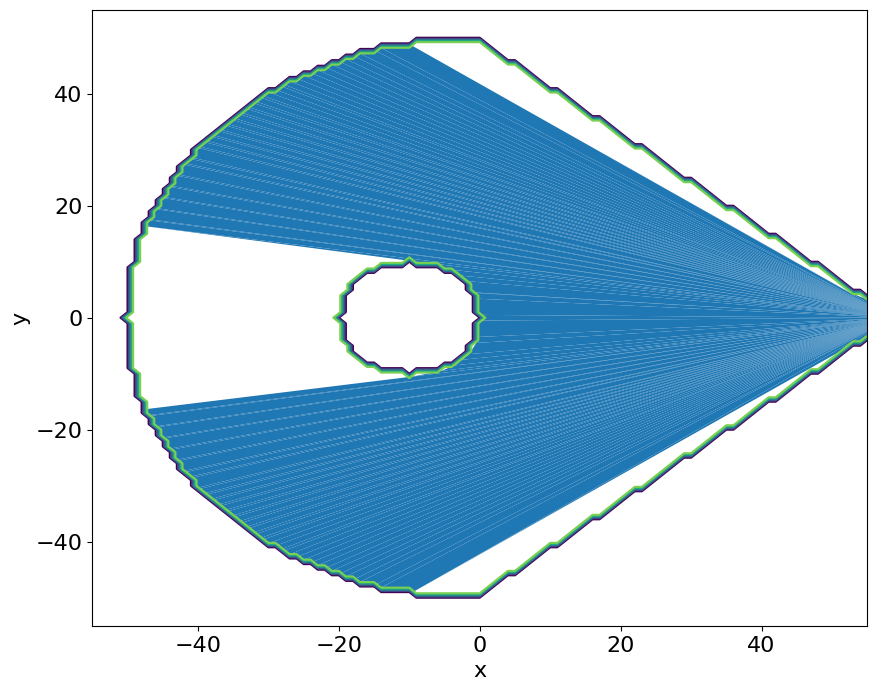

In [562]:
# itri = 0

ds.mask.plot.contour(x="x", y="y")
# plt.plot(triangles[itri,...,0], triangles[itri,...,1])
ax = plt.gca()
for itri in range(triangles.shape[0]):
    ax.add_patch(Polygon(triangles[itri, ...]))

print(triangles[itri,...])

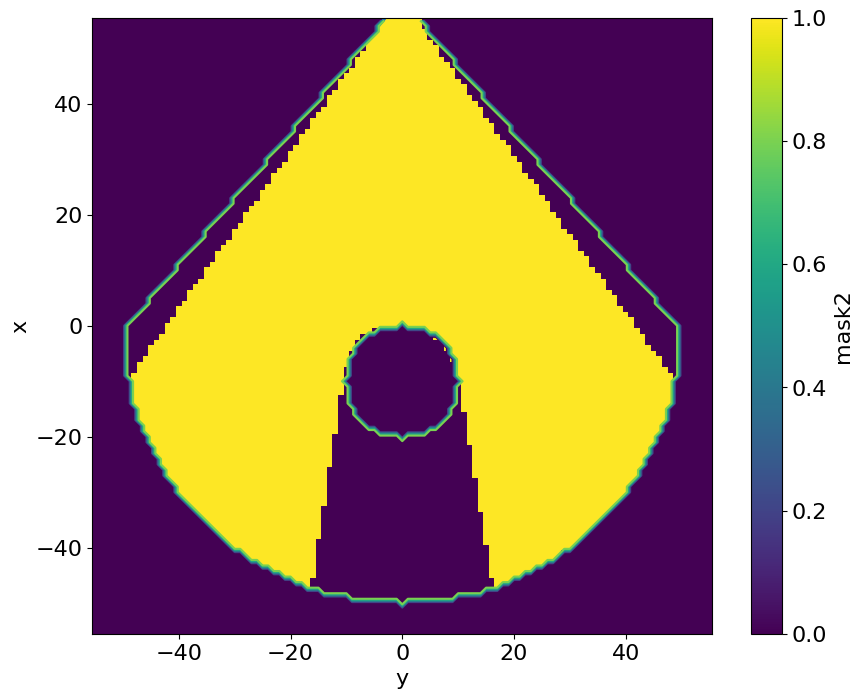

In [563]:
ds["mask2"] = ds.mask.copy()
ds["ml_"] = ds.mask.copy()

ds.mask2[...] = ml[...]
ds.ml_[...] = ml_[..., 0]
# ds.ml_[...] = ml3[..., 0]
# ds.ml_[...] = (lambda_2 + lambda_3 < 1)[..., 0]


# ds.mask.plot()
ds.mask2.plot()
# ds.ml_.plot()
ds.mask.plot.contour()

ax = plt.gca()
ax.add_patch(Polygon(np.flip(triangles[0,...], axis=1)))

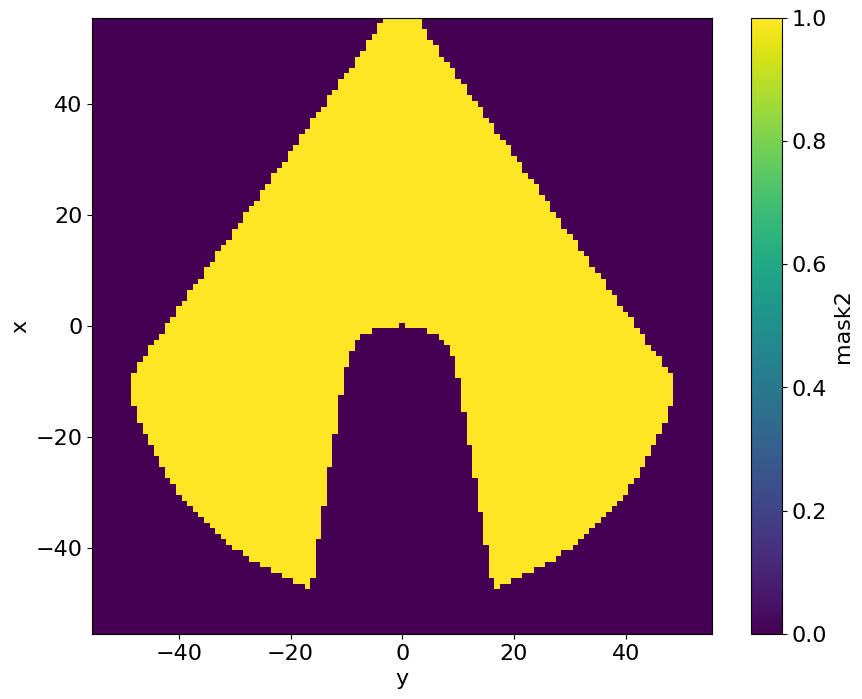

In [564]:
ds.mask2[...] = np.logical_and(ds.mask2.values, ds.mask.values)
ds.mask2.plot()

### Random Proto

In [234]:
num = np.cross(edge_pool[...,:2] - insertion_point, edge_vectors)
denum = np.cross(ray_vectors, edge_vectors[:, np.newaxis, ...]).swapaxes(0,1)
mu2d = (num/denum)
(
    num.shape,
    denum.shape,
    mu2d.shape,
)

((360,), (360, 360), (360, 360))

In [238]:
smua = (
    np.cross(edge_pool[...,:2] - insertion_point, edge_vectors) 
    / np.cross(ray_vectors[1,...], edge_vectors)
)
np.all(smua == mu2d[1, ...])

True

In [263]:
num = np.cross((insertion_point - edge_pool[..., :2])[:, np.newaxis, ...], ray_vectors).swapaxes(0, 1)
denum = np.cross(edge_vectors[:, np.newaxis, ...], ray_vectors).swapaxes(0, 1)
nu2d = (num/denum)
(
    num.shape,
    denum.shape,
    nu2d.shape,
)

((360, 360), (360, 360), (360, 360))

In [267]:
ii = 33
# np.all(num[ii, ...] == np.cross(insertion_point - edge_pool[..., :2], ray_vectors[ii, ...]))
# np.all(denum[ii, ...] == np.cross(edge_vectors, ray_vectors[ii, ...]))
# np.all(num[ii, ...] / denum[ii, ...] == np.cross(insertion_point - edge_pool[..., :2], ray_vectors[ii, ...]) / np.cross(edge_vectors, ray_vectors[ii, ...]))
np.all(nu2d[ii, ...] == np.cross(insertion_point - edge_pool[..., :2], ray_vectors[ii, ...]) / np.cross(edge_vectors, ray_vectors[ii, ...]))


True

In [89]:
edge_points[2, ...]

array([-50.5,  -0.5])

In [95]:
edge_pool[109,...]

array([-20.5,  -0.5, -20.5,   0.5])

In [101]:
np.where(np.all(edge_pool[...,:2] == edge_points[2,...], axis=1))

(array([3, 5], dtype=int64),)

In [105]:
np.arctan(1/0)

ZeroDivisionError: division by zero

In [104]:
np.pi/2

1.5707963267948966

In [112]:
np.where(dx == 0)[0].size > 0

False

In [114]:
-1*np.inf

-inf